# Работа с данными

## Импорт библиотек

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.multivariate.factor import Factor
from pandas_datareader.data import DataReader
from sklearn.metrics import mean_absolute_error
import itertools
from tqdm import tqdm
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore")

## Импорт предсказываемых факторов

Достаём данные с FRED, опубликованные в период 1979-01-01 — 2024-01-01

In [2]:
start = '1979-01-01'
end = '2024-01-01'
array, names = [], []

In [3]:
# Функция, которая агрегирует данные по квартилям (по последнему доступному значению) и записывает данные и их названия в соответствующие массивы
def data(df, name, array, names):
    df = df.resample('Q').last()
    df.index = df.index.to_period('Q').to_timestamp()
    array.append(df)
    names.append(name)
    return df, array, names

1. Банковские кредиты

In [4]:
TOTBKCR, array, names = data(DataReader('TOTBKCR', 'fred', start=start, end=end), 'BankCredits', array, names)

2. Кредиты на недвижимость

In [5]:
RELACBW027SBOG, array, names = data(DataReader('RELACBW027SBOG', 'fred', start=start, end=end), 'RealEstateLoans', array, names)

## Визуализация тенденций кредитных продуктов

In [6]:
x = TOTBKCR.index
y1 = TOTBKCR['TOTBKCR'].to_numpy()
y2 = RELACBW027SBOG['RELACBW027SBOG'].to_numpy()

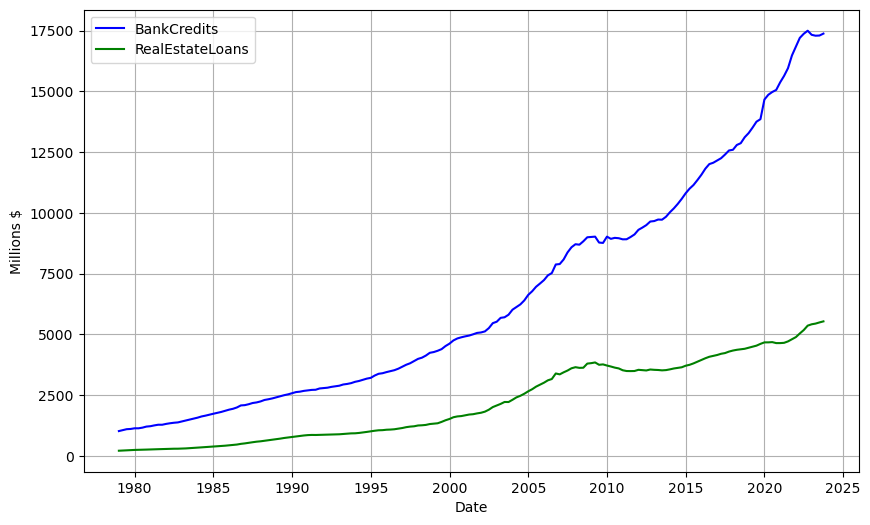

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='BankCredits', color='blue')
plt.plot(x, y2, label='RealEstateLoans', color='green')
plt.xlabel('Date')
plt.ylabel('Millions $')
plt.grid()
plt.legend()
plt.show()

## Импорт предполагаемых макроэкономических переменных

По аналогии достаём данные с FRED, опубликованные в период 1979-01-01 — 2024-01-01

In [8]:
start = '1979-01-01'
end = '2024-01-01'
variable_names = []
not_diff = []

### Макроэкономические показатели

1. Реальный располагаемый личный доход

In [9]:
DSPIC96, array, variable_names = data(DataReader('DSPIC96', 'fred', start=start, end=end), 'DSPIC96', array, variable_names)

2. Валовой внутренний продукт

In [10]:
GDP, array, variable_names = data(DataReader('GDP', 'fred', start=start, end=end), 'GDP', array, variable_names)

3. Уровень безработицы

In [11]:
UNRATE, array, variable_names = data(DataReader('UNRATE', 'fred', start=start, end=end), 'UNRATE', array, variable_names)
not_diff.append('UNRATE')

4. Совпадающий индекс экономической активности

In [12]:
USPHCI, array, variable_names = data(DataReader('USPHCI', 'fred', start=start, end=end), 'USPHCI', array, variable_names)
not_diff.append('USPHCI')

5. Индекс промышленного производства

In [13]:
INDPRO, array, variable_names = data(DataReader('INDPRO', 'fred', start=start, end=end), 'INDPRO', array, variable_names)
not_diff.append('INDPRO')

6. Общее количество наемных работников в несельскохозяйственных отраслях

In [14]:
PAYEMS, array, variable_names = data(DataReader('PAYEMS', 'fred', start=start, end=end), 'PAYEMS', array, variable_names)

7. Индекс потребительских цен без учета продуктов питания и энергии

In [15]:
CPILFESL, array, variable_names = data(DataReader('CPILFESL', 'fred', start=start, end=end), 'CPILFESL', array, variable_names)
not_diff.append('CPILFESL')

8. Эффективная ставка по федеральным фондам

In [16]:
FEDFUNDS, array, variable_names = data(DataReader('FEDFUNDS', 'fred', start=start, end=end), 'FEDFUNDS', array, variable_names)
not_diff.append('FEDFUNDS')

9. Изменения базовой процентной ставки по кредитам

In [17]:
DPRIME, array, variable_names = data(DataReader('DPRIME', 'fred', start=start, end=end), 'DPRIME', array, variable_names)
not_diff.append('DPRIME')

10. Рыночная доходность казначейских ценных бумаг США с постоянным сроком погашения 5 лет

In [18]:
DGS5, array, variable_names = data(DataReader('DGS5', 'fred', start=start, end=end), 'DGS5', array, variable_names)
not_diff.append('DGS5')

11. Процентные ставки по депозитам

In [19]:
IR3TCD01USM156N, array, variable_names = data(DataReader('IR3TCD01USM156N', 'fred', start=start, end=end), 'IR3TCD01USM156N', array, variable_names)
not_diff.append('IR3TCD01USM156N')

12. Ставка личных сбережений

In [20]:
PSAVERT, array, variable_names = data(DataReader('PSAVERT', 'fred', start=start, end=end), 'PSAVERT', array, variable_names)
not_diff.append('PSAVERT')

13. Индекс потребительских настроений

In [21]:
UMCSENT, array, variable_names = data(DataReader('UMCSENT', 'fred', start=start, end=end), 'UMCSENT', array, variable_names)
not_diff.append('UMCSENT')

14. Рыночная доходность казначейских ценных бумаг США с постоянным сроком погашения 10 лет

In [22]:
GS10, array, variable_names = data(DataReader('GS10', 'fred', start=start, end=end), 'GS10', array, variable_names)
not_diff.append('GS10')

15. Доходность 3-месячных казначейских векселей

In [23]:
DTB3, array, variable_names = data(DataReader('DTB3', 'fred', start=start, end=end), 'DTB3', array, variable_names)
not_diff.append('T10Y2Y')

16. Личные потребительские расходы

In [24]:
PCE, array, variable_names = data(DataReader('PCE', 'fred', start=start, end=end), 'PCE', array, variable_names)

17. Корпоративная прибыль до налогообложения

In [25]:
A053RC1Q027SBEA, array, variable_names = data(DataReader('A053RC1Q027SBEA', 'fred', start=start, end=end), 'A053RC1Q027SBEA', array, variable_names)

18. Индекс цен на коммерческую недвижимость

In [26]:
BOGZ1FL075035503Q, array, variable_names = data(DataReader('BOGZ1FL075035503Q', 'fred', start=start, end=end), 'BOGZ1FL075035503Q', array, variable_names)
not_diff.append('BOGZ1FL075035503Q')

19. Коэффициент вакантных площадей

In [27]:
RRVRUSQ156N, array, variable_names = data(DataReader('RRVRUSQ156N', 'fred', start=start, end=end), 'RRVRUSQ156N', array, variable_names)
not_diff.append('RRVRUSQ156N')

20. Средняя цена продажи домов

In [28]:
MSPUS, array, variable_names = data(DataReader('MSPUS', 'fred', start=start, end=end), 'MSPUS', array, variable_names)

21. Количество единиц новых частных жилых домов

In [29]:
HOUST, array, variable_names = data(DataReader('HOUST', 'fred', start=start, end=end), 'HOUST', array, variable_names)

22. Количество продаж новых частных домов

In [30]:
HSN1F, array, variable_names = data(DataReader('HSN1F', 'fred', start=start, end=end), 'HSN1F', array, variable_names)

23. Спотовая цена на сырую нефть

In [31]:
WTISPLC, array, variable_names = data(DataReader('WTISPLC', 'fred', start=start, end=end), 'WTISPLC', array, variable_names)

24. Денежная база

In [32]:
BOGMBASE, array, variable_names = data(DataReader('BOGMBASE', 'fred', start=start, end=end), 'BOGMBASE', array, variable_names)

25. Индекс потребительских цен

In [33]:
CORESTICKM159SFRBATL, array, variable_names = data(DataReader('CORESTICKM159SFRBATL', 'fred', start=start, end=end), 'CORESTICKM159SFRBATL', array, variable_names)
not_diff.append('CORESTICKM159SFRBATL')

26. Индекс потребительских цен для всех городских потребителей

In [34]:
CPIAUCSL, array, variable_names = data(DataReader('CPIAUCSL', 'fred', start=start, end=end), 'CPIAUCSL', array, variable_names)
not_diff.append('CPIAUCSL')

27. Цепной индекс цен

In [35]:
PCEPI, array, variable_names = data(DataReader('PCEPI', 'fred', start=start, end=end), 'PCEPI', array, variable_names)
not_diff.append('PCEPI')

28. Денежная масса M2

In [36]:
M2SL, array, variable_names = data(DataReader('M2SL', 'fred', start=start, end=end), 'M2SL', array, variable_names)

29. Рост населения

In [37]:
POPTHM, array, variable_names = data(DataReader('POPTHM', 'fred', start=start, end=end), 'POPTHM', array, variable_names)

30. Уровень участия в рабочей силе

In [38]:
CIVPART, array, variable_names = data(DataReader('CIVPART', 'fred', start=start, end=end), 'CIVPART', array, variable_names)
not_diff.append('CIVPART')

31. Население трудоспособного возраста (15-64 года

In [39]:
LFWA64TTUSM647S, array, variable_names = data(DataReader('LFWA64TTUSM647S', 'fred', start=start, end=end), 'LFWA64TTUSM647S', array, variable_names)

### Фичи

32. Фича = разности DPRIME(9) и FEDFUNDS (1)

In [40]:
combined_data = pd.merge(FEDFUNDS, DPRIME, left_index=True, right_index=True, how='inner')
combined_data['RateDifference'] = combined_data['DPRIME'] - combined_data['FEDFUNDS']
RateDifference = combined_data['RateDifference']
variable_names.append('RateDifference')
array.append(RateDifference)
not_diff.append('RateDifference')

In [41]:
# В not_diff будут храниться макроэкономические переменные, которые интересно рассматривать не только как разности, но и в оригинальном виде
not_diff = set(not_diff)

## Создание датасета со всеми макроэкономическими переменными и факторами

In [42]:
dta = pd.concat(array, axis=1)
names = names + variable_names
dta.columns = names
dta.index.freq = dta.index.inferred_freq
dta.sample()

BankCredits  RealEstateLoans  DSPIC96       GDP  UNRATE  USPHCI  \
DATE                                                                          
1981-01-01    1224.8175         267.0716   5264.4  3124.206     7.4   47.67   

             INDPRO  PAYEMS  CPILFESL  FEDFUNDS  ...  WTISPLC  BOGMBASE  \
DATE                                             ...                      
1981-01-01  50.9806   91210      86.4      14.7  ...     38.0     159.8   

            CORESTICKM159SFRBATL  CPIAUCSL   PCEPI    M2SL  POPTHM  CIVPART  \
DATE                                                                          
1981-01-01             10.319341      88.6  41.715  1636.6  229314     64.1   

            LFWA64TTUSM647S  RateDifference  
DATE                                         
1981-01-01        144575600             2.8  

[1 rows x 34 columns]

## Визуализация тенденций макроэкономических переменных

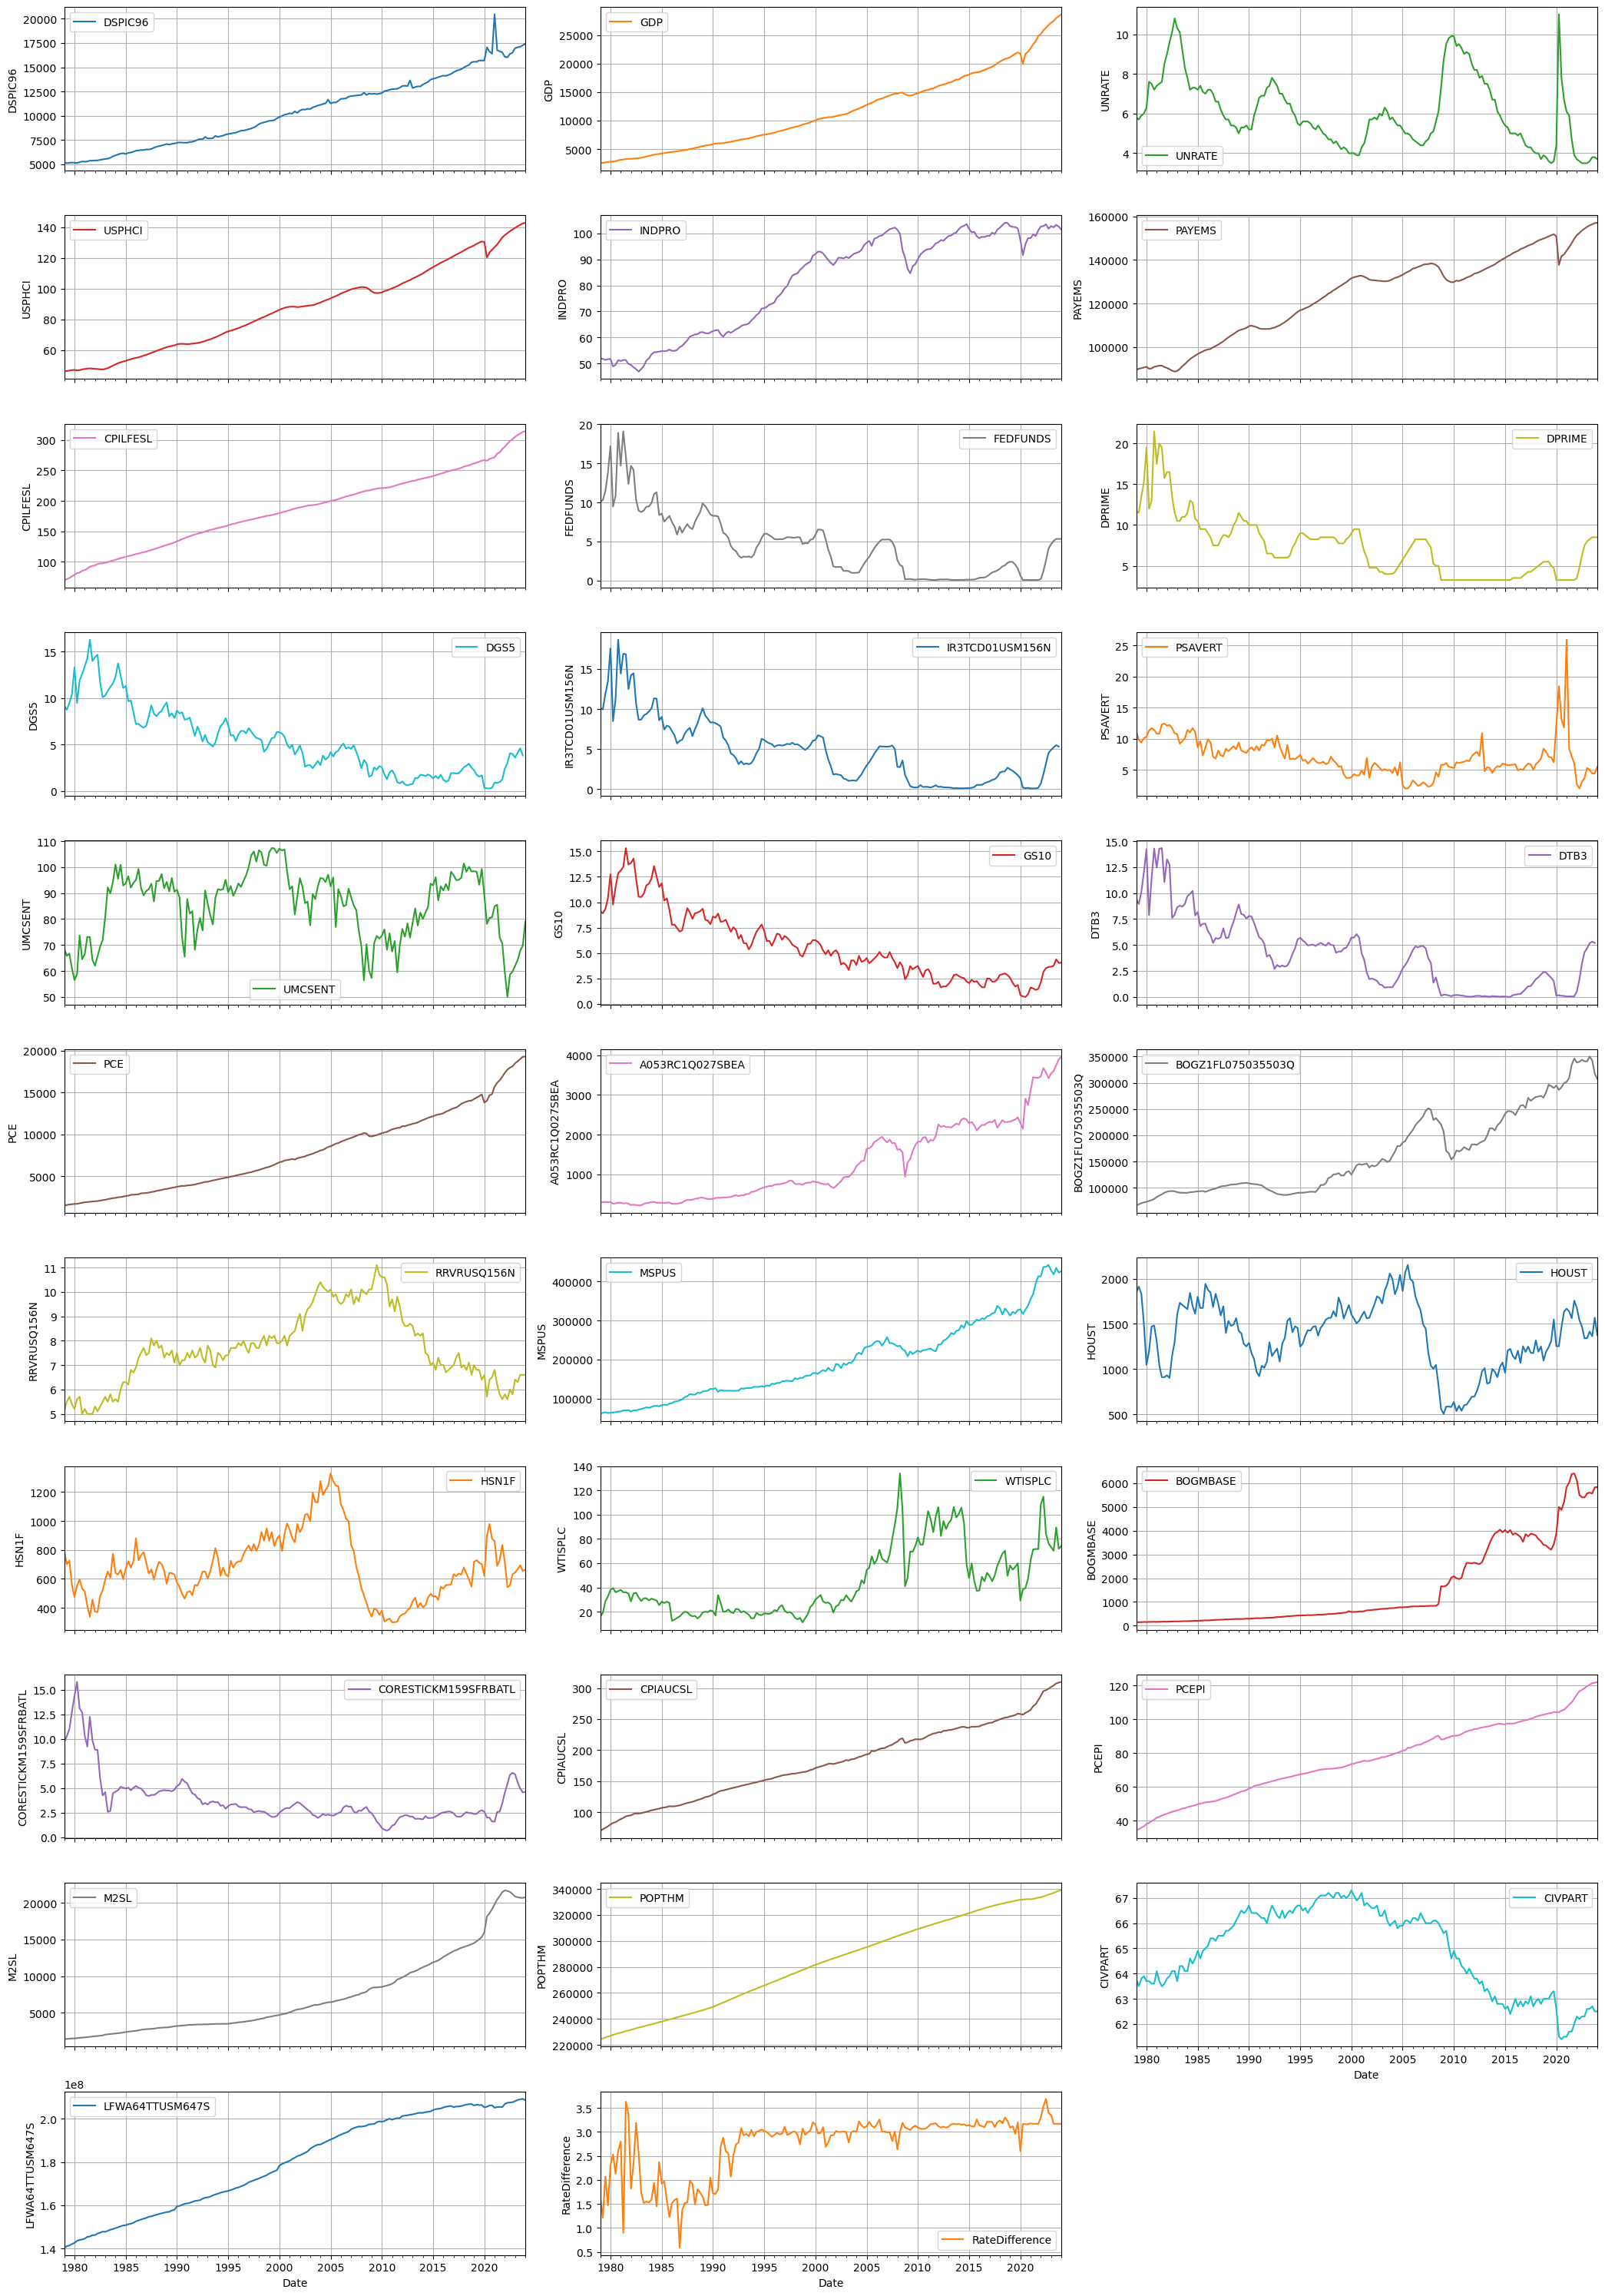

In [43]:
axes = dta[variable_names].plot(subplots=True, layout=(11, 3), figsize=(21, 30))
for i, ax in enumerate(axes.flatten()):
    if i < len(variable_names):
        ax.set_xlabel('Date')
        ax.set_ylabel(variable_names[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Чистка макроэкономических переменных от выбросов

Выбросы считаем по правилу трёх сигма

In [44]:
def outliers(df):
    for column in range(len(names)):
        mean = df[names[column]].mean()
        std = df[names[column]].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df[names[column]] = df[names[column]].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
        df[names[column]] = df[names[column]].ffill()  
    return df

In [45]:
dta = outliers(dta)

## Визуализация тенденций очищенных макроэкономических переменных

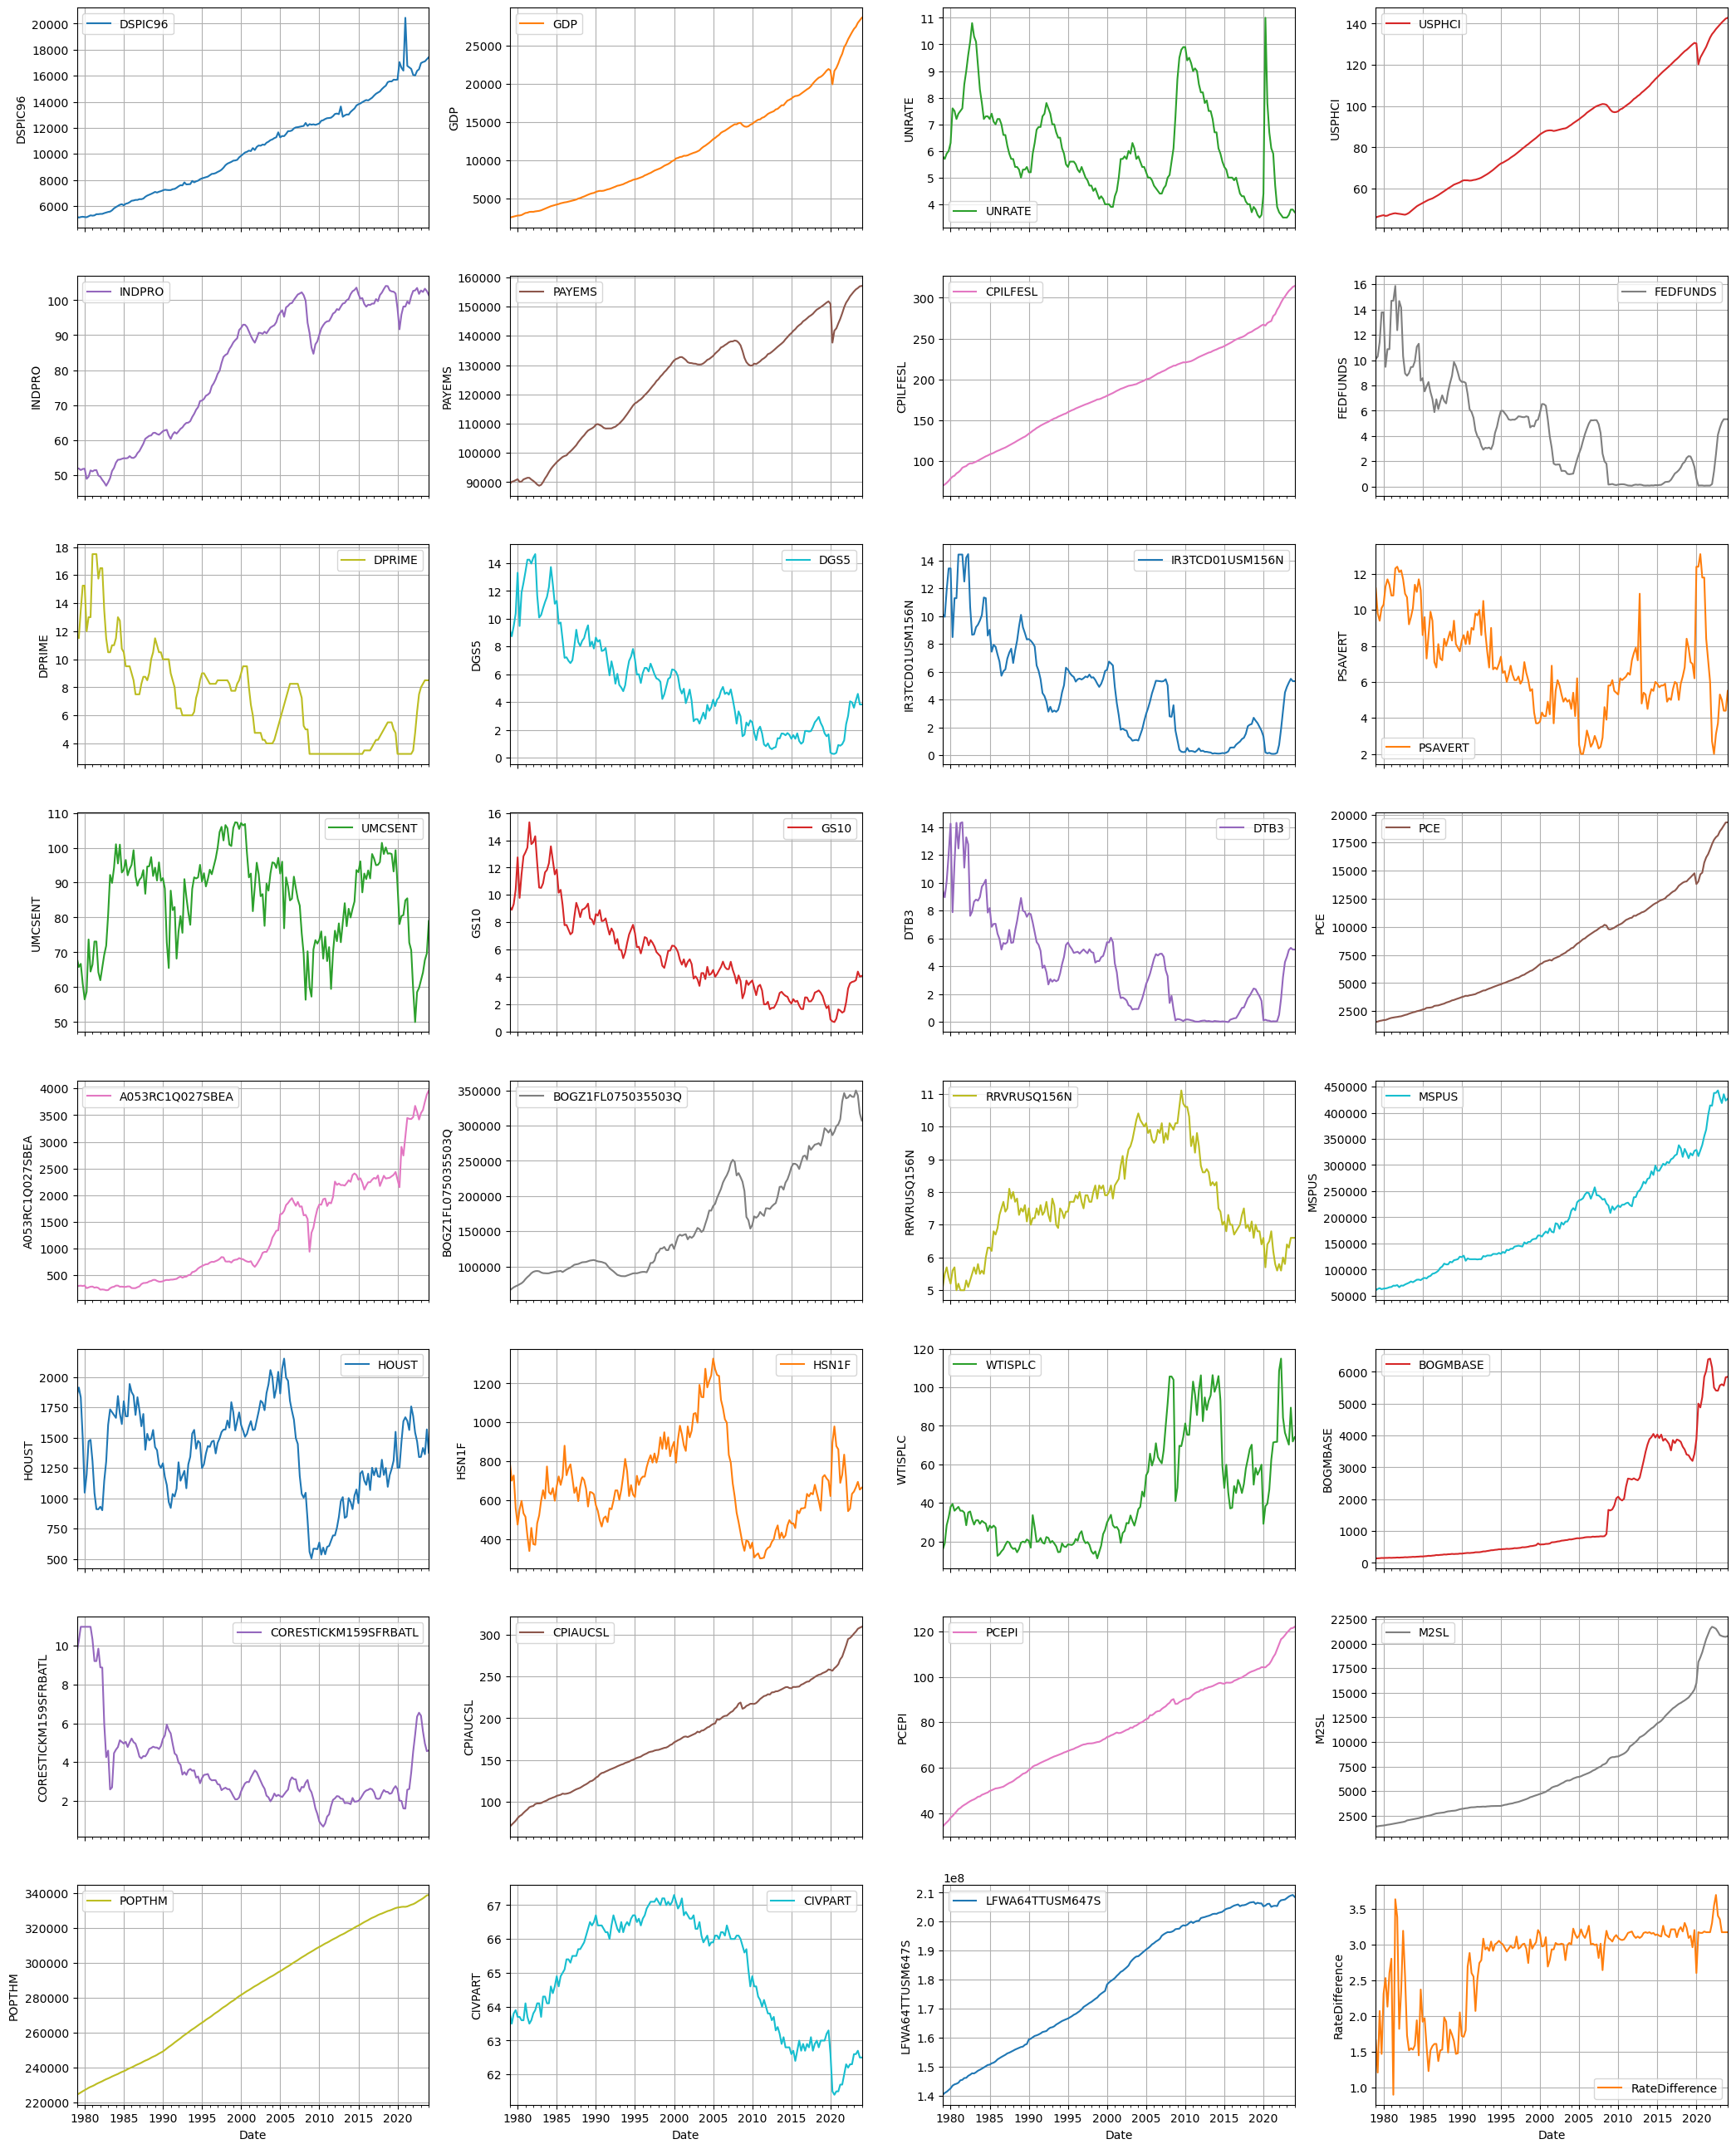

In [46]:
axes = dta[variable_names].plot(subplots=True, layout=(10, 4), figsize=(21, 32))
for i, ax in enumerate(axes.flatten()):
    if i < len(variable_names):
        ax.set_xlabel('Date')
        ax.set_ylabel(variable_names[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Нормализация переменных

In [47]:
# Функция нормализующая ряды с учётом их среднего значения и среднего квадратичного отклонения
def normalize(names, df):
    for i in range(len(names)):
        if names[i] in not_diff:
            dln_name_not_diff = 'DLN' + names[i] + 'NotDiff'
            df[dln_name_not_diff] = (np.log(df[names[i]])) * 100
            std_name_not_diff = 'STD' + names[i] + 'NotDiff'
            normal_names.append('STD' + names[i] + 'NotDiff')
            df[std_name_not_diff] = (df[dln_name_not_diff] - df[dln_name_not_diff].mean()) / df[dln_name_not_diff].std()
        dln_name = 'DLN' + names[i]
        df[dln_name] = (np.log(df[names[i]])).diff() * 100
        std_name = 'STD' + names[i]
        if names[i] != 'BankCredits' and names[i] != 'RealEstateLoans':
            normal_names.append('STD' + names[i])
        df[std_name] = (df[dln_name] - df[dln_name].mean()) / df[dln_name].std()
    return df

In [48]:
# Функция для нормализации «по окнам» ввиду изменения экономической ситуации
def normalize_by_windows(data, window_size):
    normalized_data = pd.DataFrame()
    start_date = data.index.min()
    end_date = data.index.max()
    current_start = start_date
    while current_start < end_date:
        current_end = current_start + pd.tseries.offsets.DateOffset(years=int(window_size[:-1]))
        if (end_date - current_start).days < (int(window_size[:-1]) * 365 / 2):
            current_end = end_date
        window_data = data[(data.index >= current_start) & (data.index < current_end)]
        if not window_data.empty:
            normalized_window = normalize(names, window_data)
            normalized_data = pd.concat([normalized_data, normalized_window])
        current_start = current_end 
    normalized_data = normalized_data.dropna()
    return normalized_data

## Общие функции расчётов

In [49]:
# Функция, которая ищет все корреляции c заданным таргетом
def all_correlation(dta, normal_variable, name):
    answer, variables, normalize_correlation = [], [], []
    for i in range(len(normal_variable)):
        spearman_corr_normalize = pd.Series(dta['STD' + name]).corr(dta[normal_variable[i]], method='spearman')
        answer.append([abs(spearman_corr_normalize), spearman_corr_normalize, normal_variable[i]])
    answer.sort(reverse=True)
    for i in range(len(answer)):
        variables.append(answer[i][2])
        normalize_correlation.append(round(answer[i][1], 4))
    df = pd.DataFrame({
    'Variable': variables,
    'Correlation': normalize_correlation})
    return df

In [50]:
# Функция, отбирающая все переменные, у которых корреляция с таргетом > threshold
def highlight_rows(row, threshold):
    return ['background-color: yellow' if abs(row['Correlation']) > threshold else '' for i in row]

# Работа с данными для спроса на ипотеки

In [51]:
# Для ипотек оказалась достаточно эффективной нормировка внутри 13летних окон
normal_names = []
dta_loans = dta.copy()
dta_loans = normalize_by_windows(dta_loans, '13Y')
normal_names = list(set(normal_names))
normal_names.sort()

## Визуализация тенденций нормализированных ипотек

In [52]:
x = dta_loans.index
y = dta_loans['STDRealEstateLoans'].to_numpy()

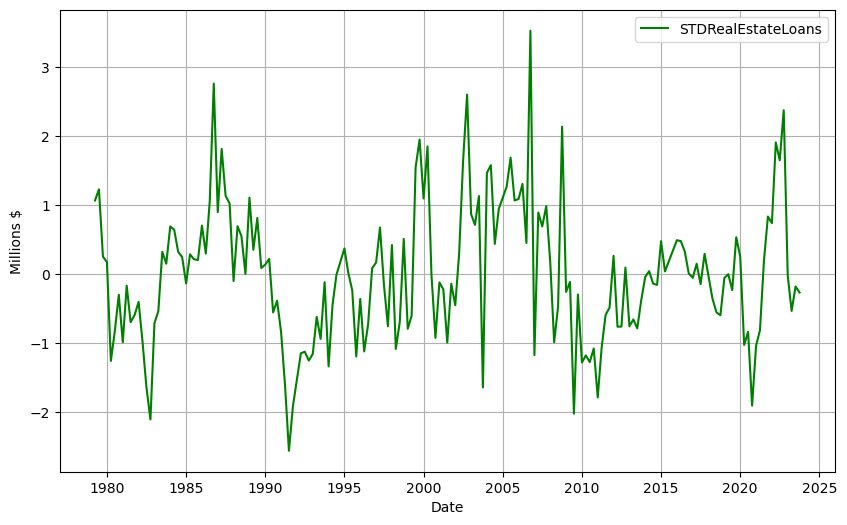

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='STDRealEstateLoans', color='green')
plt.xlabel('Date')
plt.ylabel('Millions $')
plt.grid()
plt.legend()
plt.show()

## Визуализация тенденций нормализованных макроэкономических переменных

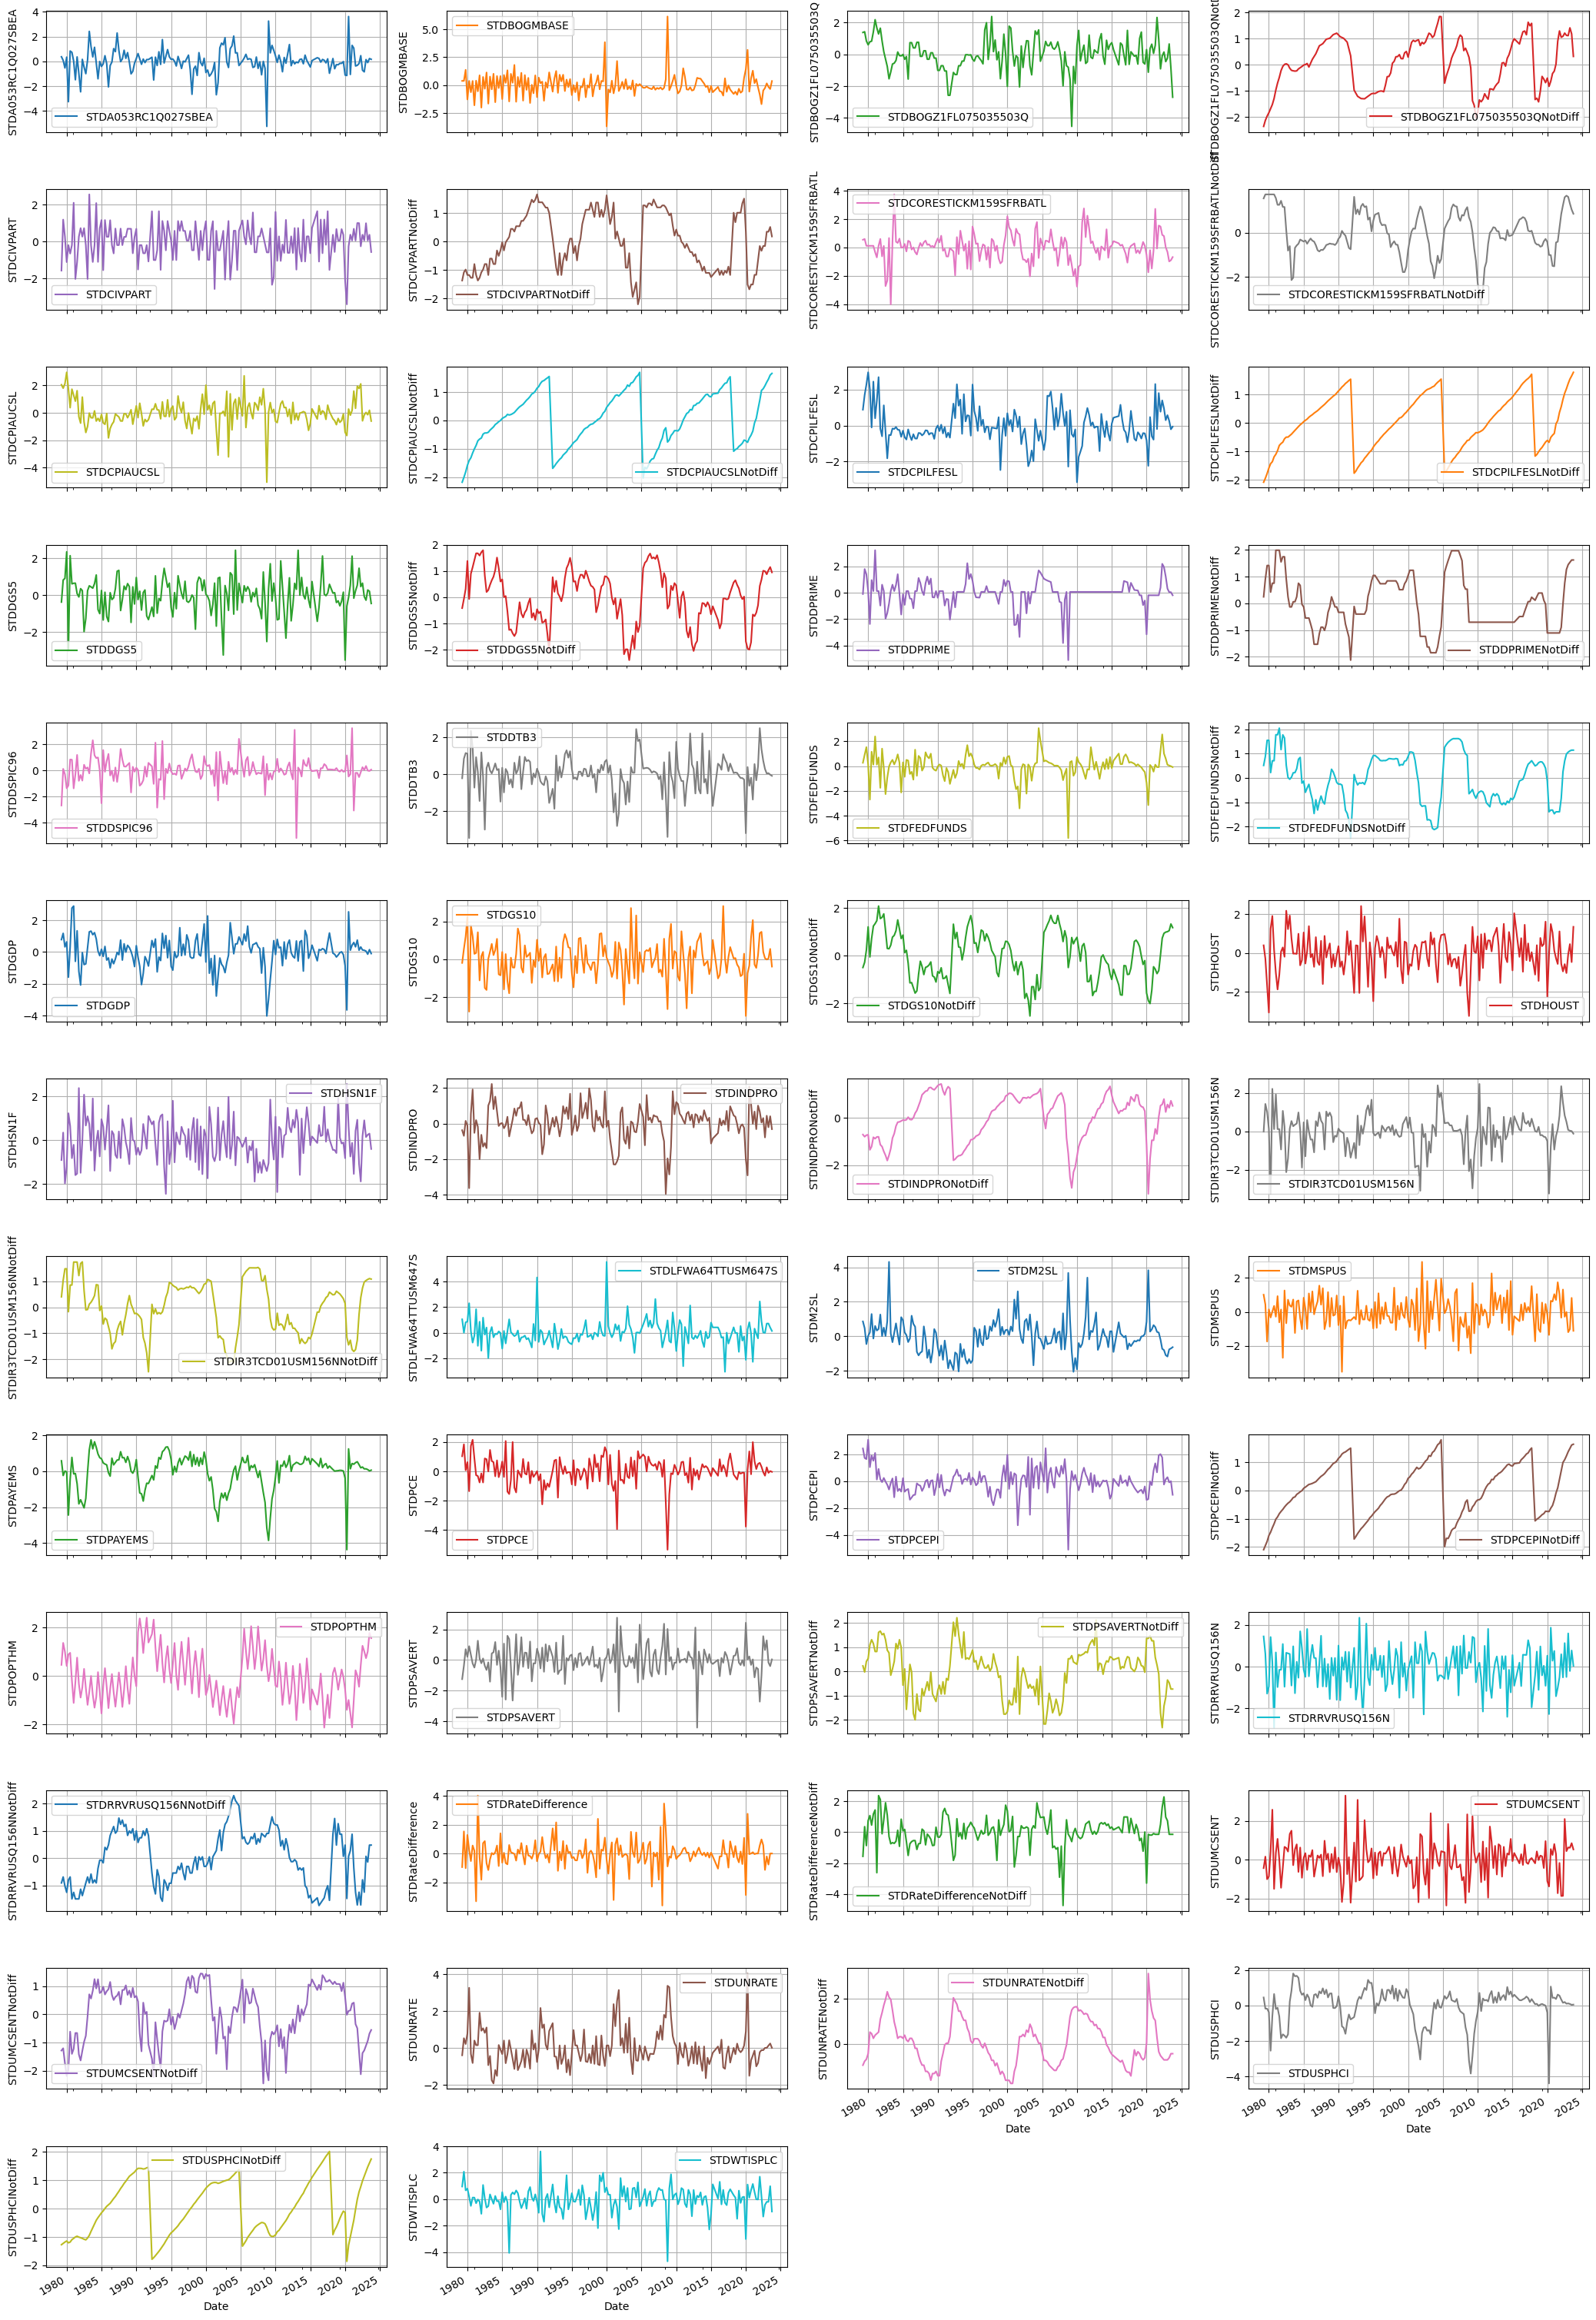

In [54]:
axes = dta_loans[normal_names].plot(subplots=True, layout=(14, 4), figsize=(21, 32))
for i, ax in enumerate(axes.flatten()):
    if i < len(normal_names):
        ax.set_xlabel('Date')
        ax.set_ylabel(normal_names[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Корреляции между нормализованными макроэкономическими переменными

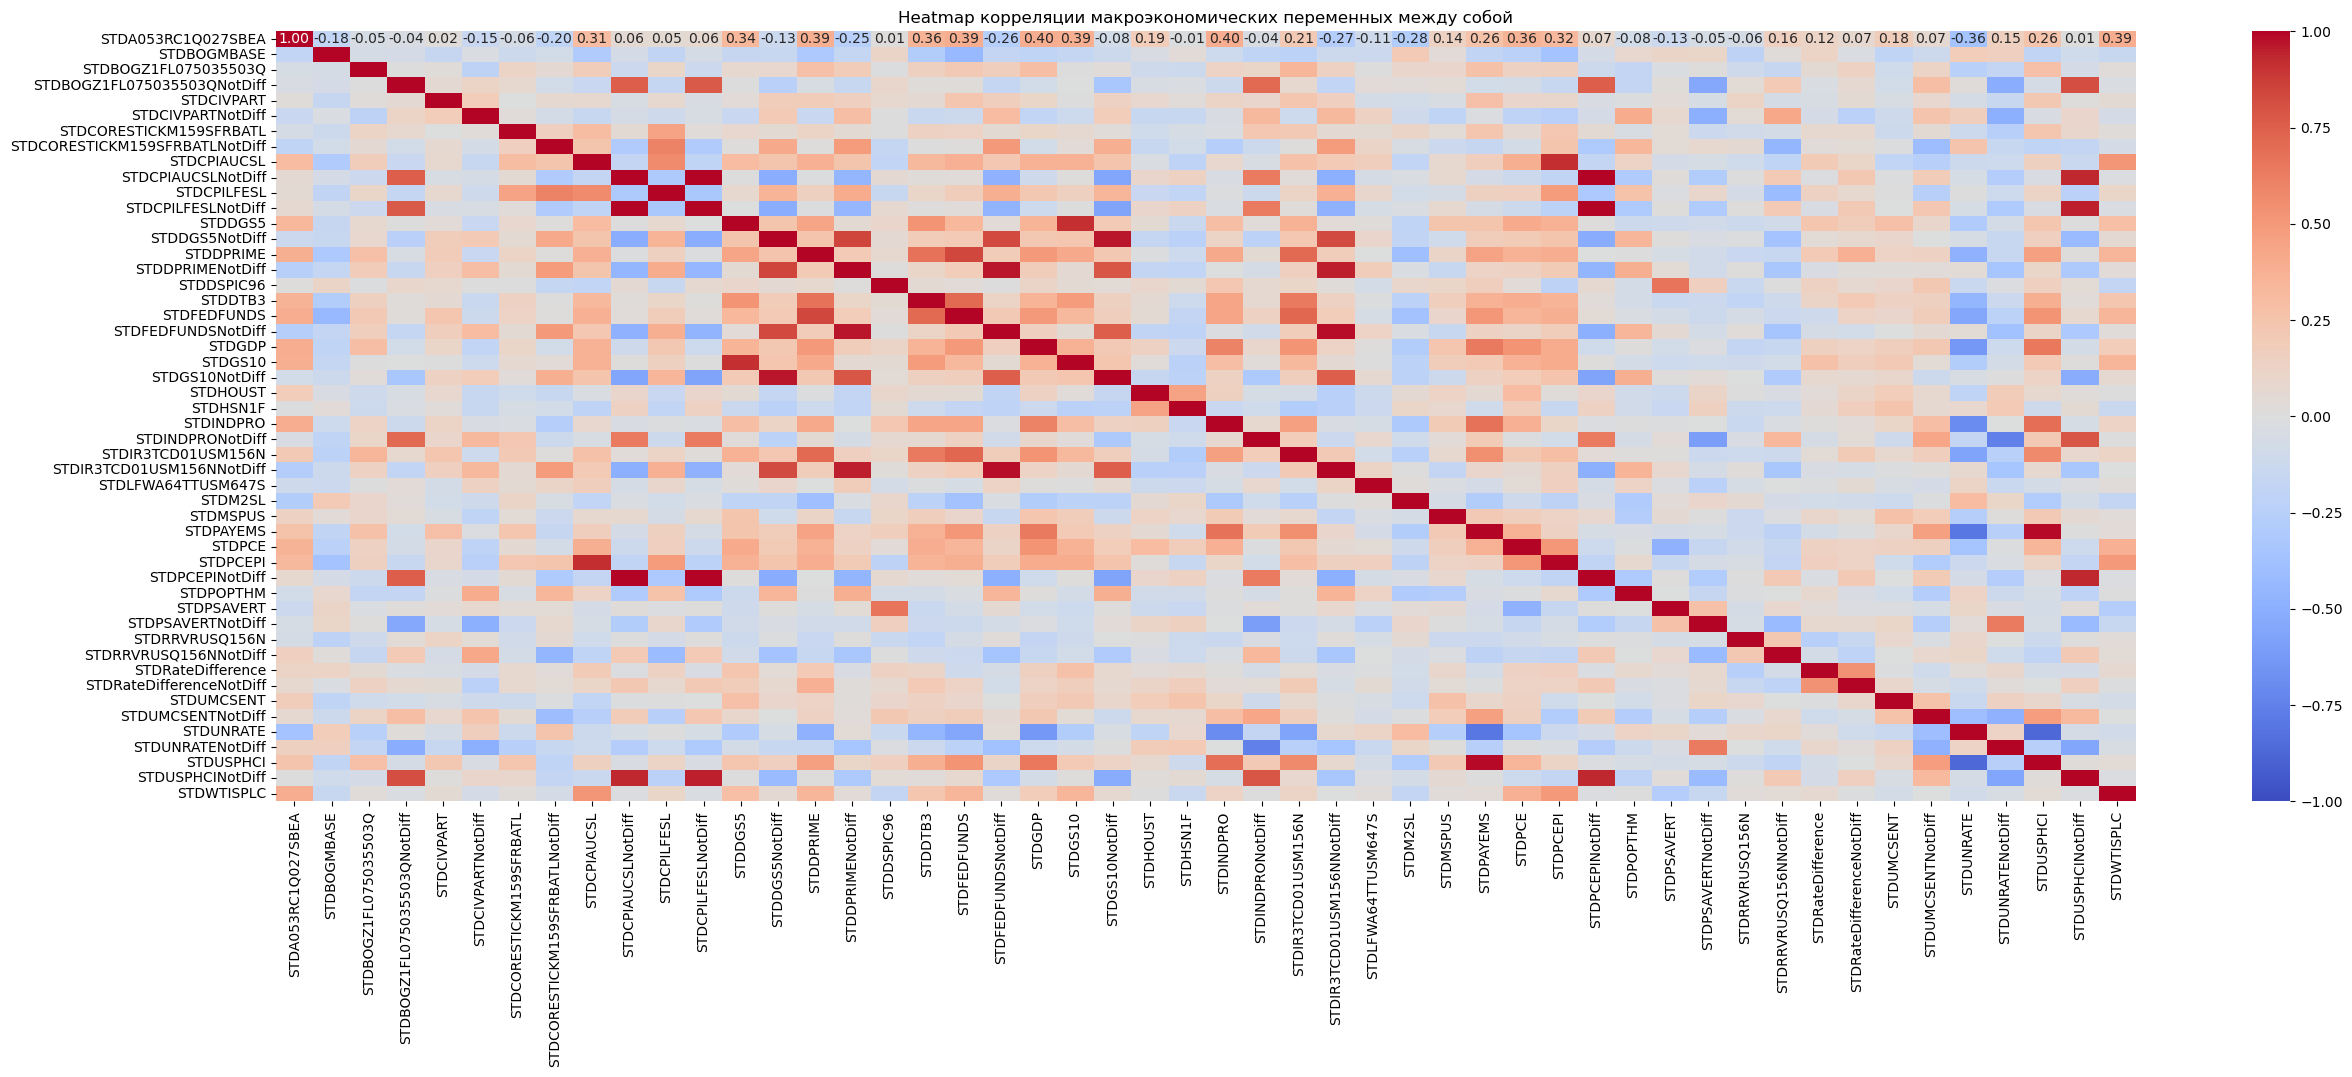

In [55]:
plt.figure(figsize=(30, 10))
sns.heatmap(dta_loans[normal_names].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap корреляции макроэкономических переменных между собой')
plt.show()

## Поиск корреляций Спирмена для кредитов на недвижимость

In [56]:
# Отобранные на этом этапе переменные пойдут в факторный анализ
RealEstateLoans_corr = all_correlation(dta_loans, normal_names, 'RealEstateLoans')
RealEstateLoans_corr.style.apply(highlight_rows, threshold=0.25, axis=1)

# Факторный анализ для предсказания спроса на ипотеки

In [57]:
# Отобранные на этом этапе переменные пойдут в модели
columns_to_use = ['STDPSAVERTNotDiff', 'STDUNRATENotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDINDPRONotDiff', 'STDFEDFUNDS', 'STDDPRIME', 'STDUMCSENTNotDiff', 'STDUSPHCINotDiff', 'STDIR3TCD01USM156N']
fa = Factor(dta_loans.loc['1972-01-01':, columns_to_use], n_factor=1, method='pa')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

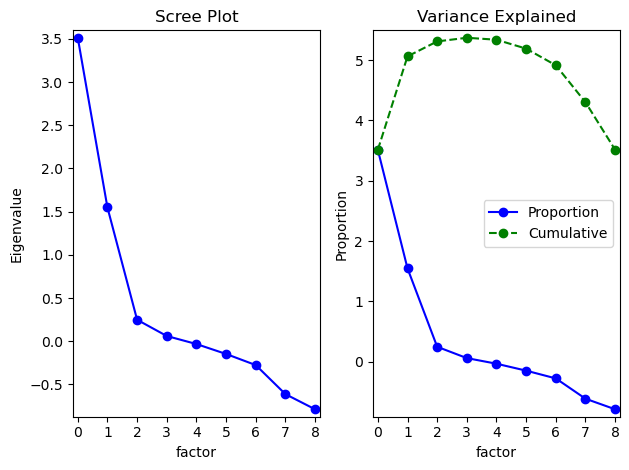

In [58]:
res.plot_scree()
plt.show()

# DFM, предсказывающая спрос на ипотеки

## Ошибки, к которым стремимся

In [59]:
# Для начала хотелось бы достичь того, что MAE составляло бы не более 15% от диапазона, то есть
(dta_loans['STDRealEstateLoans'].max() - dta_loans['STDRealEstateLoans'].min()) * 0.15

0.9133285505435341

## Подбор данных и метода подгонки, на которых модель имеет наименьшее MAE

In [60]:
# Функция, которая измеряет MAE модели по переданным переменным и параметрам
def evaluate_combination(df, combination, target, endog, method):
    endog_subset = endog[list(combination)]
    mod = sm.tsa.DynamicFactorMQ(endog_subset)
    initial_res = mod.fit(method=method)
    res = mod.fit(start_params=initial_res.params)
    res = mod.filter(params=res.params)
    mae = mean_absolute_error(df.loc['1979-04-01':, target].values , res.factors.filtered.iloc[:, 0].values)
    return mae

In [61]:
# Функция, строящая модели на всех доступных наборах переменных и с разными параметрами
def adjustment(helper, columns_to_use, name):
    endog = helper.loc['1979-04-01':, columns_to_use]
    methods = ['nm', 'powell']
    min_mae = float('inf')
    best_combination = None
    best_method = None
    counter = 0
    for r in range(4, len(columns_to_use) + 1):
        for combination in itertools.combinations(columns_to_use, r):
            for i in range(len(methods)):
                counter += 1
    with tqdm(total=counter, desc="Progress", unit="comb") as pbar:
        for r in range(4, len(columns_to_use) + 1):
            for combination in itertools.combinations(columns_to_use, r):
                for i in range(len(methods)):
                    mae = evaluate_combination(helper, combination, name, endog, methods[i])
                    if mae < min_mae:
                        min_mae = mae
                        best_combination = combination
                        best_method = methods[i]
                    pbar.update(1)
    print(f"Лучшая комбинация: {best_combination}")
    print(f"Лучший метод: {best_method}")
    print(f"Минимальное MAE: {min_mae}")
    return best_combination

In [62]:
columns_to_use = ['STDPSAVERTNotDiff', 'STDUNRATENotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDINDPRONotDiff', 'STDUMCSENTNotDiff', 'STDUSPHCINotDiff']
columns_to_use = adjustment(dta_loans, columns_to_use, 'STDRealEstateLoans')

Progress: 100%|██████████████████████████████████████████████████████████████████████| 44/44 [02:30<00:00,  3.43s/comb]

Лучшая комбинация: ('STDPSAVERTNotDiff', 'STDUNRATENotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDUMCSENTNotDiff')
Лучший метод: powell
Минимальное MAE: 0.7119518031002573


## Построение модели с подобранными данными

In [63]:
columns_to_use = ['STDPSAVERTNotDiff', 'STDUNRATENotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDUMCSENTNotDiff']
endog = dta_loans.loc['1979-04-01':, columns_to_use]
mod = sm.tsa.DynamicFactorMQ(endog, standartize=False)
initial_res = mod.fit(method='powell')
res = mod.fit(start_params=initial_res.params)
res = mod.filter(params=res.params)

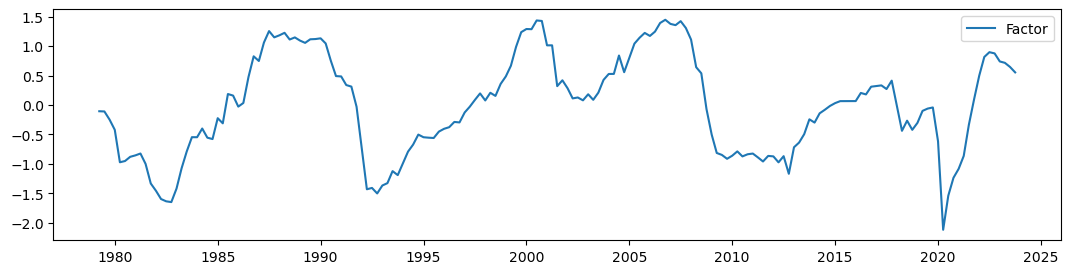

In [64]:
# Отрисовка полученного фактора
fig, ax = plt.subplots(figsize=(13, 3))
dates = endog.index._mpl_repr()
factor_values = res.factors.filtered.iloc[:, 0] * 0.9
ax.plot(dates, factor_values, label='Factor')
ax.legend()
plt.show()

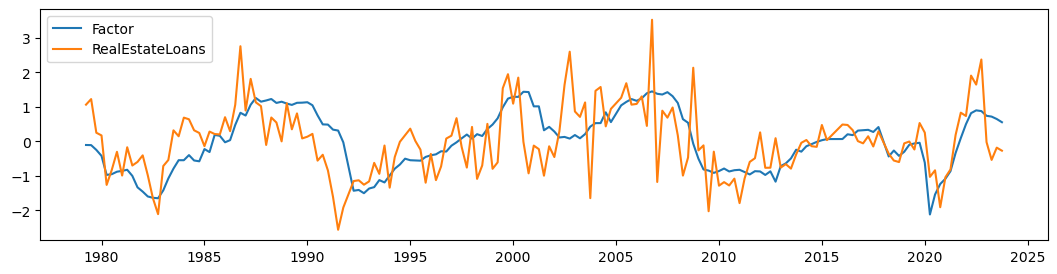

In [65]:
# Отрисовка полученного фактора и истинных значений для сравнения
fig, ax = plt.subplots(figsize=(13,3))
dates = endog.index._mpl_repr()
ax.plot(dates, factor_values, label='Factor')
ax.plot(dates, dta_loans.loc['1979-04-01':, ['STDRealEstateLoans']], label='RealEstateLoans')
ax.legend()
plt.show()

In [66]:
# Контрольный рассчёт ошибки MAE
mae = mean_absolute_error(dta_loans.loc['1979-04-01':, 'STDRealEstateLoans'].values, factor_values)
print(f"MAE: {mae}")

MAE: 0.6751848474961124


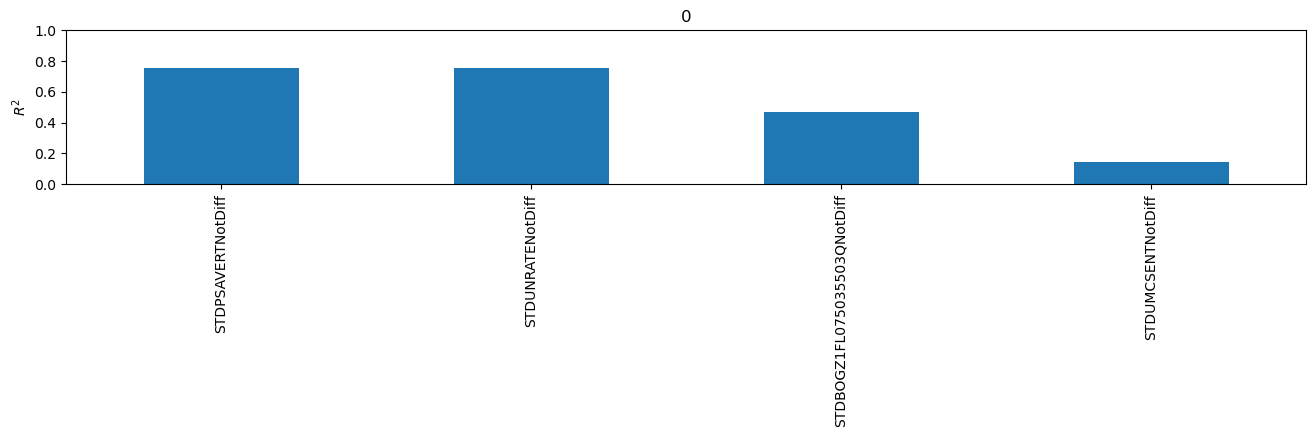

In [67]:
# Просмотр полученных коэффициентов для переменных
res.plot_coefficients_of_determination(figsize=(16,2));

# VAR, предсказывающая спрос на ипотеки

In [68]:
# # Функция, строящая модели на всех доступных наборах переменных и с разным количеством лагов, впоследствии отбирающая лучшую модель по IС и MAE 
def optimize_var(helper, columns_to_use, name):
    endog = helper.loc['1979-01-01':, columns_to_use]
    criterions = ['aic', 'bic']
    min_mae = float('inf')
    best_combination = None
    best_lag = None
    best_ic = None
    counter = 0
    for r in range(3, len(columns_to_use) + 1):
        for combination in itertools.combinations(columns_to_use, r):
            for i in range(len(criterions)):
                counter += 1
    with tqdm(total=counter, desc="Progress", unit="comb") as pbar:
        for r in range(3, len(columns_to_use) + 1):
            for combination in itertools.combinations(columns_to_use, r):
                for ic in criterions:
                    try:
                        predictions = []
                        actuals = []
                        dates = []
                        current_vars = list(combination)
                        current_vars.append(name)
                        train = helper.loc['1979-01-01':, current_vars].iloc[:40]
                        endog = helper.loc['1979-01-01':, current_vars]
                        model = VAR(train)
                        selected_order = model.select_order(maxlags=4)
                        lags = selected_order.selected_orders[ic]
                        for i in range(40 + lags, len(endog)):
                            train_data = endog.iloc[i-40:i]
                            model = VAR(train_data)
                            fitted_model = model.fit(lags)
                            forecast = fitted_model.forecast(train_data.values[-lags:], steps=1)
                            pred = forecast[0][endog.columns.get_loc(name)]
                            predictions.append(pred)
                            actuals.append(endog[name].iloc[i])
                            dates.append(endog.index[i])
                        results = pd.DataFrame({'date': dates, 'actual': actuals, 'forecast': predictions}).set_index('date')
                        mae = mean_absolute_error(results['actual'], results['forecast'])
                        if mae < min_mae:
                            min_mae = mae
                            best_combination = current_vars
                            best_lag = lags
                            best_ic = ic
                    except:
                        pbar.update(1)
                        continue
                    pbar.update(1)
    print(f"Лучшая комбинация: {best_combination}")
    print(f"Критерий выбора лагов: {best_ic.upper()}")
    print(f"Оптимальное количество лагов: {best_lag}")
    print(f"Минимальное MAE: {min_mae:.4f}")
    return best_combination

In [69]:
columns_to_use = ['STDPSAVERTNotDiff', 'STDUNRATENotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDINDPRONotDiff', 'STDUMCSENTNotDiff', 'STDUSPHCINotDiff']
columns_to_use = optimize_var(dta_loans, columns_to_use, 'STDRealEstateLoans')

Progress: 100%|██████████████████████████████████████████████████████████████████████| 84/84 [00:56<00:00,  1.50comb/s]

Лучшая комбинация: ['STDPSAVERTNotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDUMCSENTNotDiff', 'STDRealEstateLoans']
Критерий выбора лагов: BIC
Оптимальное количество лагов: 1
Минимальное MAE: 0.6851


## Построение модели с подобранными данными

In [70]:
predictions = []
actuals = []
dates = []
endog = dta_loans.loc['1979-01-01':, ['STDPSAVERTNotDiff', 'STDBOGZ1FL075035503QNotDiff', 'STDUMCSENTNotDiff', 'STDRealEstateLoans']]
for i in range(40 + 1, len(endog)):
    train_data = endog.iloc[i - 40:i]
    model = VAR(train_data)
    fitted_model = model.fit(1)
    forecast = fitted_model.forecast(train_data.values[-1:], steps=1)
    pred = forecast[0][endog.columns.get_loc('STDRealEstateLoans')]
    predictions.append(pred)
    actuals.append(endog['STDRealEstateLoans'].iloc[i])
    dates.append(endog.index[i])
    results = pd.DataFrame({'date': dates, 'actual': actuals, 'forecast': predictions}).set_index('date')

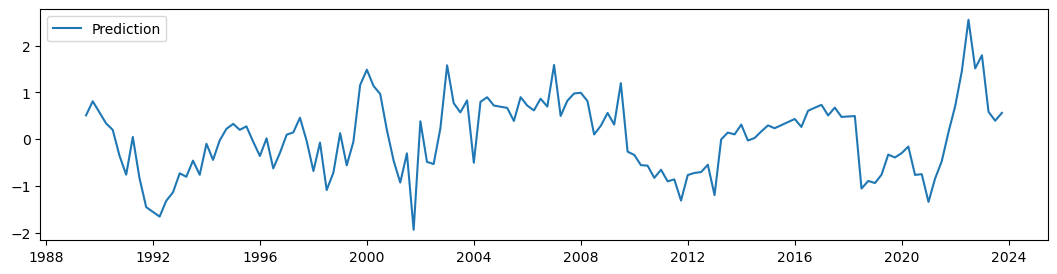

In [71]:
# Отрисовка полученных предиктов
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(results.index, results['forecast'], label='Prediction')
ax.legend()
plt.show()

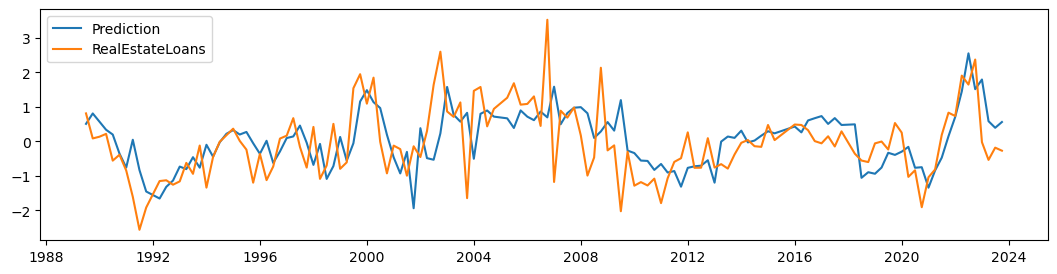

In [72]:
# Отрисовка полученных предиктов и истинных значений для сравнения
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(results.index, results['forecast'], label='Prediction')
ax.plot(results.index, results['actual'], label='RealEstateLoans')
ax.legend()
plt.show()

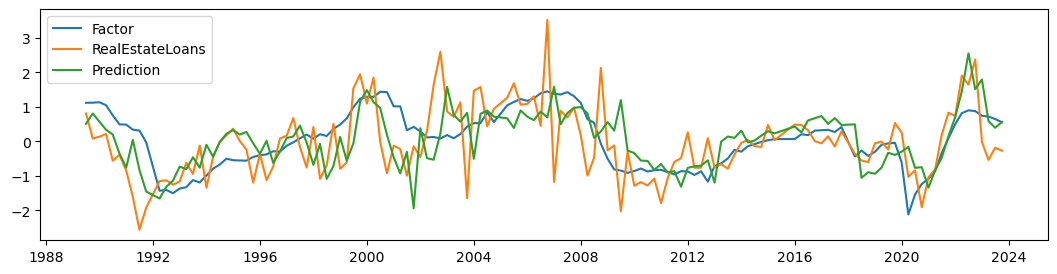

In [73]:
# Отрисовка полученного в DFM фактора, полученных в VAR предиктов и истинных значений для сравнения
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(results.index, factor_values[41:], label='Factor')
ax.plot(results.index, results['actual'], label='RealEstateLoans')
ax.plot(results.index, results['forecast'], label='Prediction')
ax.legend()
plt.show()

# Работа с данными для спроса на кредиты

In [74]:
# Для кредитов оказалась достаточно эффективной нормировка внутри 12летних окон
normal_names = []
dta_credits = dta.copy()
dta_credits = normalize_by_windows(dta_credits, '12Y')
normal_names = list(set(normal_names))
normal_names.sort()
dta_credits.sample()

BankCredits  RealEstateLoans  DSPIC96        GDP  UNRATE  USPHCI  \
DATE                                                                           
2005-01-01    6628.5332        2661.9885  11268.8  12767.286     5.2   93.64   

             INDPRO  PAYEMS  CPILFESL  FEDFUNDS  ...  DLNCIVPARTNotDiff  \
DATE                                             ...                      
2005-01-01  96.4345  133152     200.1      2.63  ...         418.813844   

            STDCIVPARTNotDiff  DLNCIVPART  STDCIVPART  DLNLFWA64TTUSM647S  \
DATE                                                                        
2005-01-01           0.718142         0.0    0.358618            0.304307   

            STDLFWA64TTUSM647S  DLNRateDifferenceNotDiff  \
DATE                                                       
2005-01-01            0.782968                  113.7833   

            STDRateDifferenceNotDiff  DLNRateDifference  STDRateDifference  
DATE                                                                        
2005-01-01                  0.363687           0.966191           0.214249  

[1 rows x 138 columns]

## Визуализация тенденций нормализированных банковских кредитов

In [75]:
x = dta_credits.index
y = dta_credits['STDBankCredits'].to_numpy()

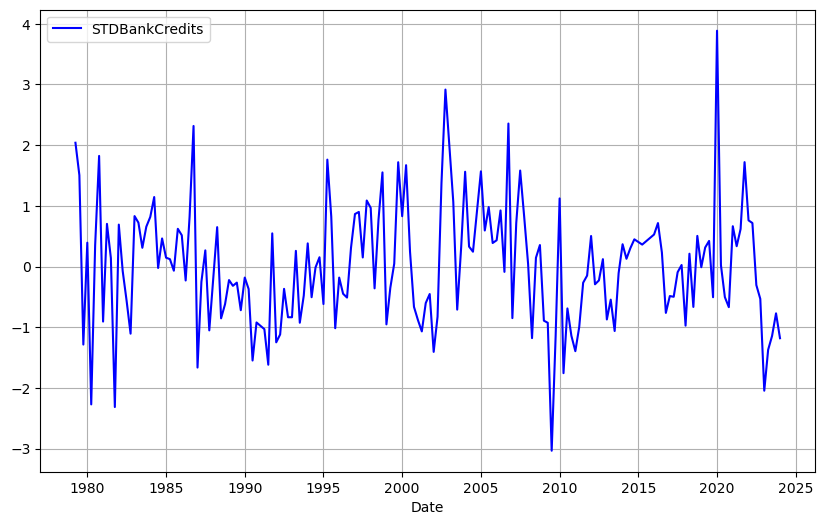

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='STDBankCredits', color='blue')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

## Визуализация тенденций нормализованных макроэкономических переменных

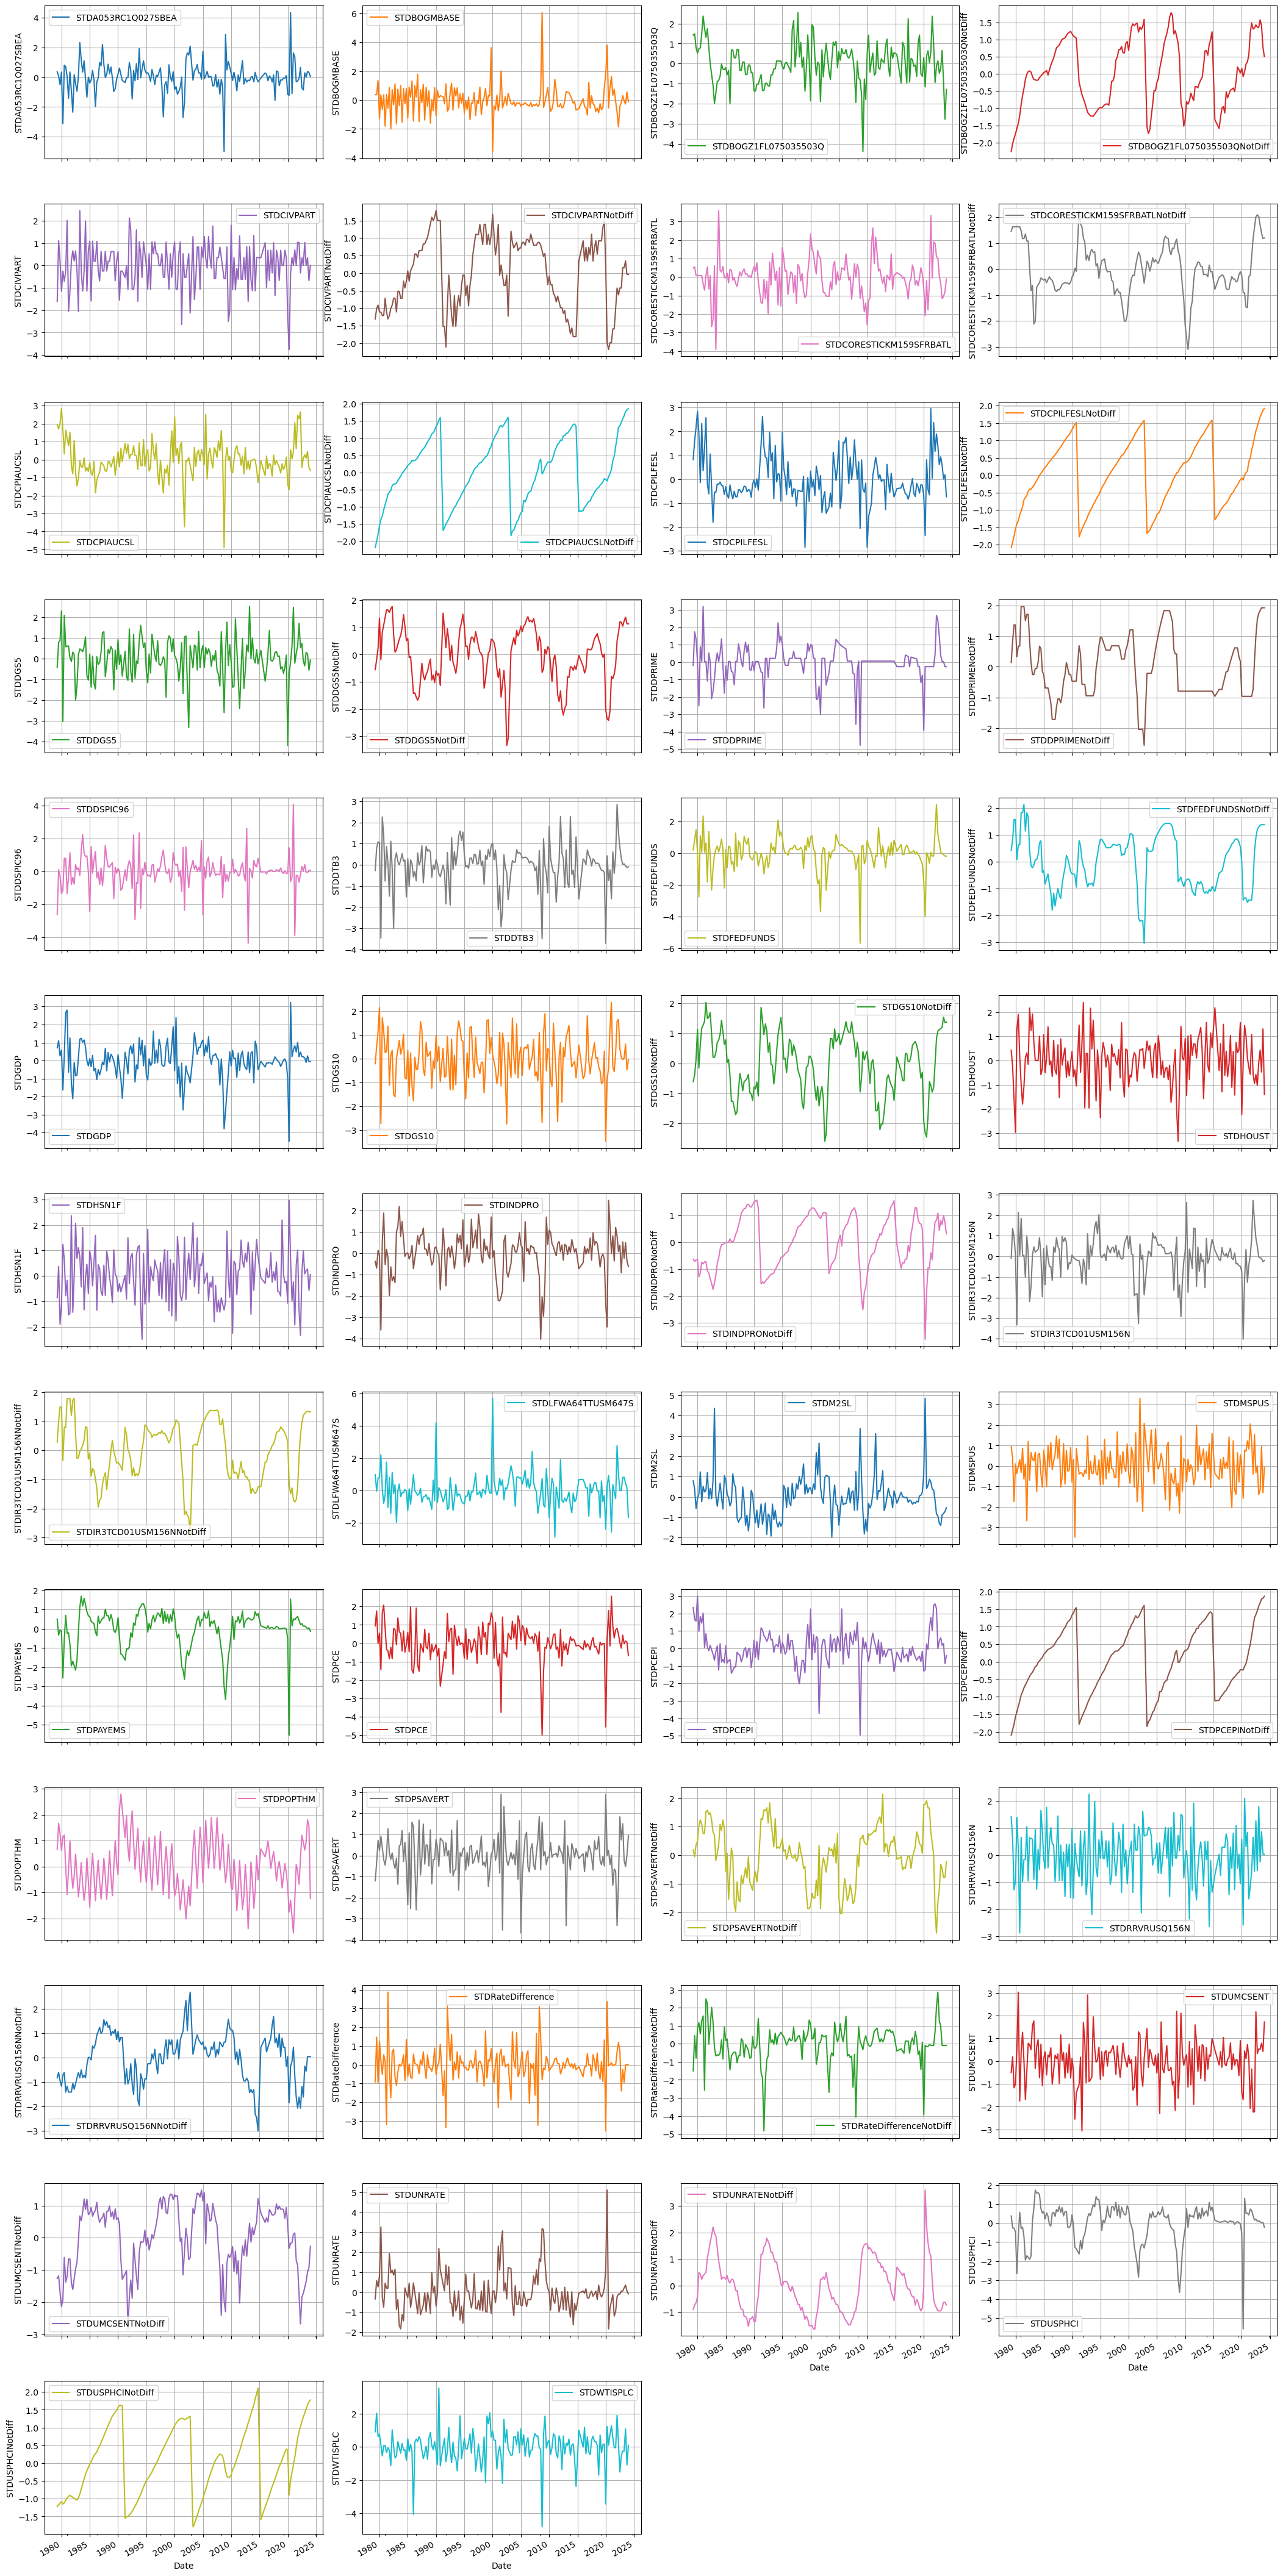

In [77]:
axes = dta_credits[normal_names].plot(subplots=True, layout=(14, 4), figsize=(21, 45))
for i, ax in enumerate(axes.flatten()):
    if i < len(normal_names):
        ax.set_xlabel('Date')
        ax.set_ylabel(normal_names[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Корреляции между нормализованными макроэкономическими переменными

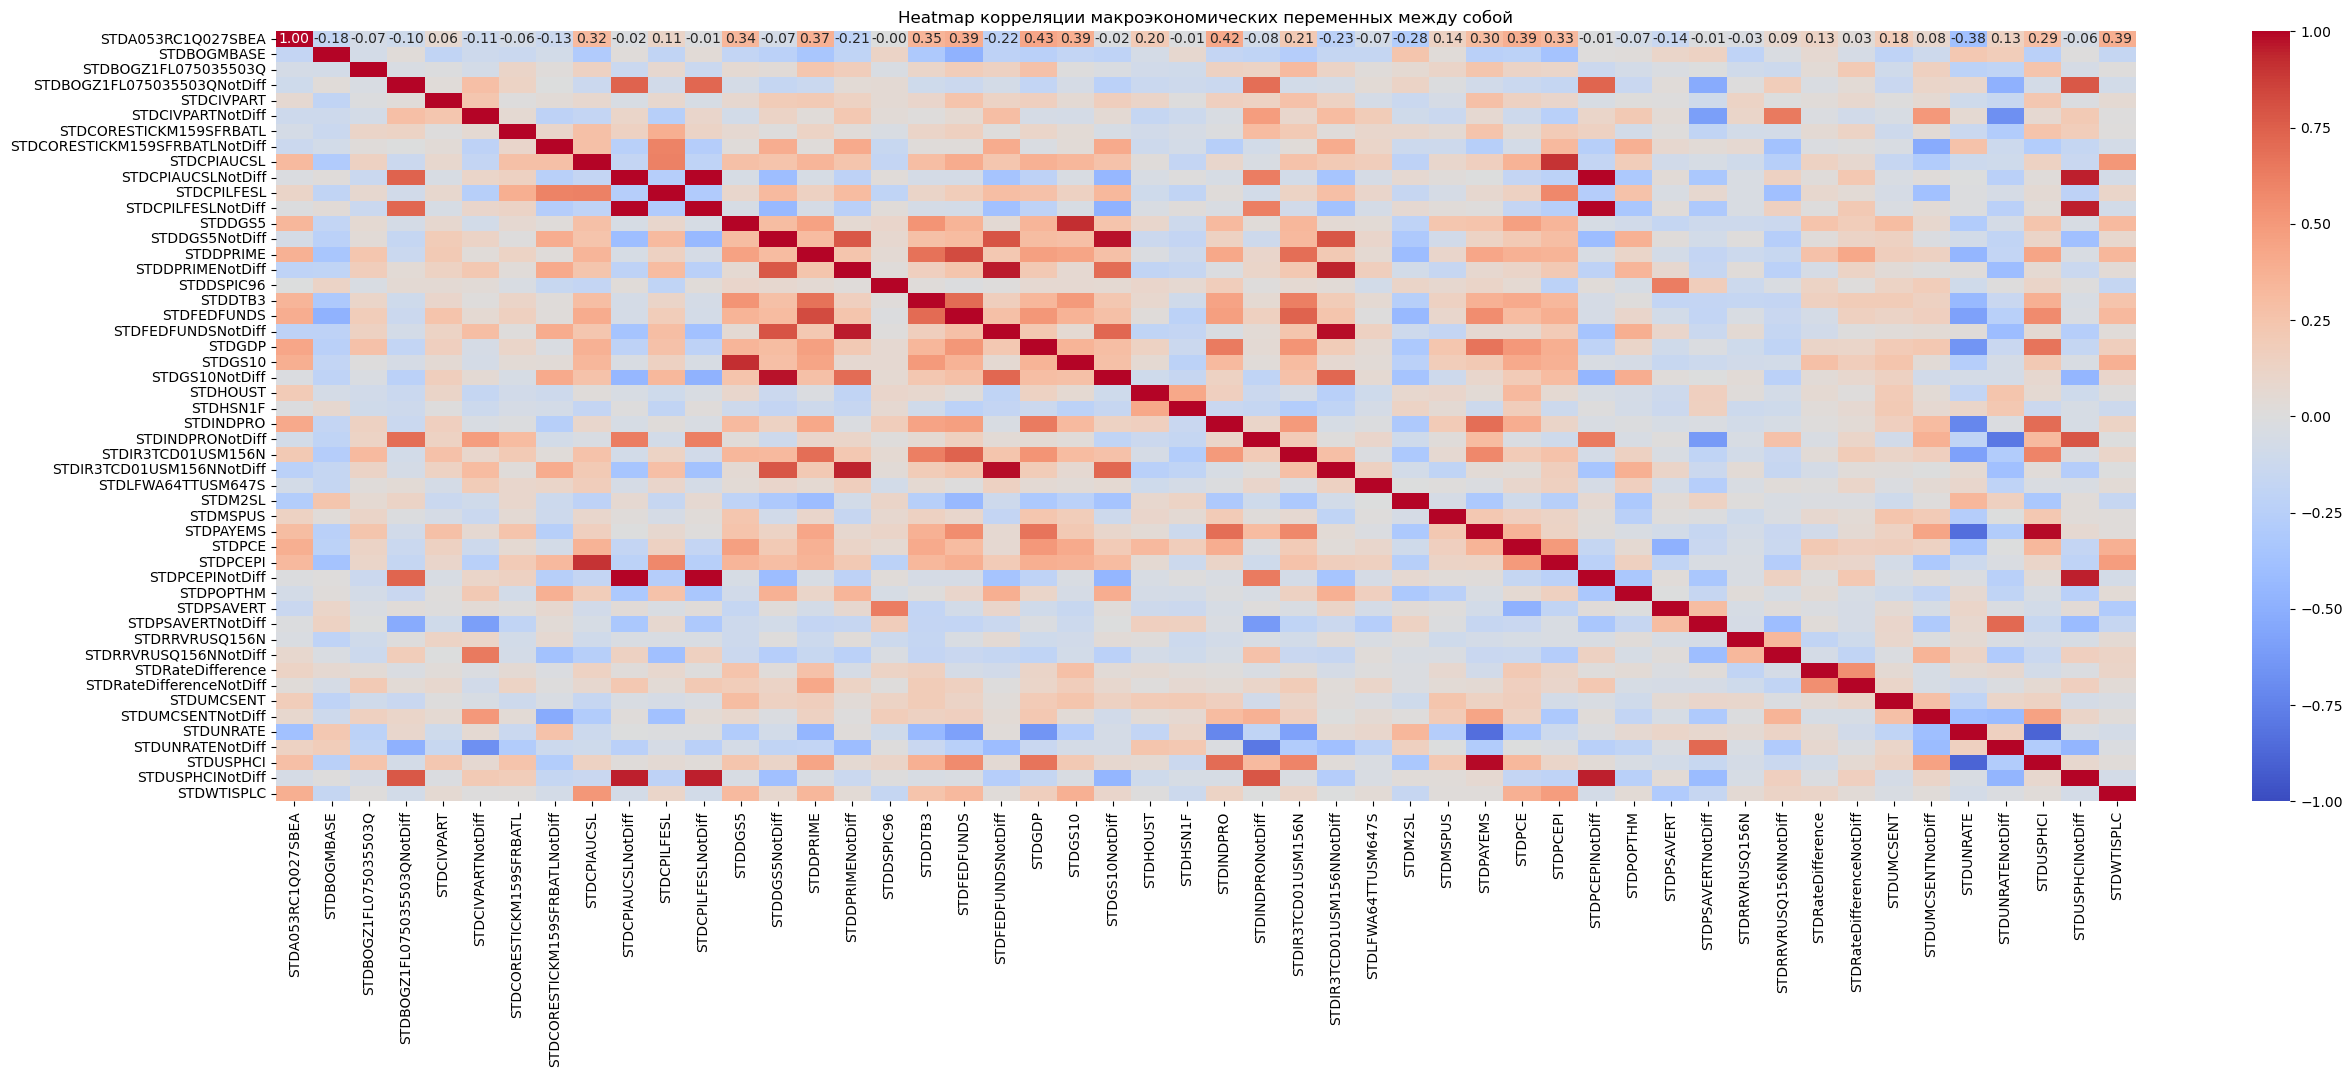

In [78]:
plt.figure(figsize=(30, 10))
sns.heatmap(dta_credits[normal_names].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap корреляции макроэкономических переменных между собой')
plt.show()

## Поиск корреляций Спирмена для банковских кредитов

In [79]:
# Отобранные на этом этапе переменные пойдут в факторный анализ
BankCredits_corr = all_correlation(dta_credits, normal_names, 'BankCredits')
BankCredits_corr.style.apply(highlight_rows, threshold=0.25, axis=1)

# Факторный анализ для предсказания спроса на кредиты

In [80]:
# Отобранные на этом этапе переменные пойдут в модели
columns_to_use = ['STDM2SL', 'STDUMCSENTNotDiff', 'STDPAYEMS', 'STDFEDFUNDS',
       'STDBOGZ1FL075035503Q', 'STDUSPHCI', 'STDPCE']
fa = Factor(dta_credits.loc['1972-01-01':, columns_to_use], n_factor=1, method='pa')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

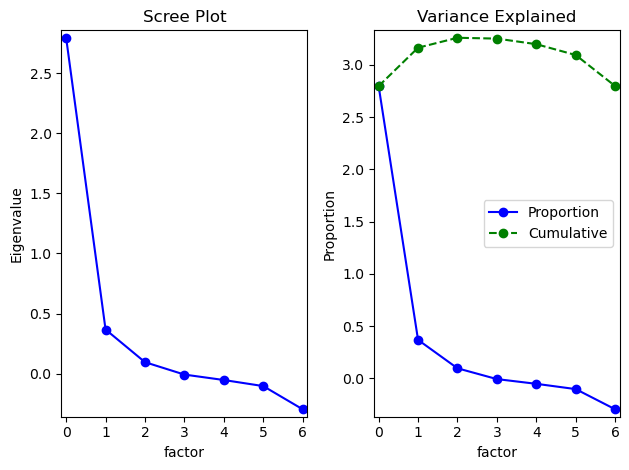

In [81]:
res.plot_scree()
plt.show()

# DFM, предсказывающая спрос на кредиты

## Ошибки, к которым стремимся

In [82]:
# Для начала хотелось бы достичь того, что MAE составляло бы не более 15% от диапазона, то есть
(dta_credits['STDBankCredits'].max() - dta_credits['STDBankCredits'].min()) * 0.15

1.0378771286612674

## Подбор данных и метода подгонки, на которых модель имеет наименьшее MAE

In [83]:
columns_to_use = ['STDM2SL', 'STDUMCSENTNotDiff', 'STDPAYEMS', 'STDFEDFUNDS', 'STDUSPHCI', 'STDPCE']
columns_to_use = adjustment(dta_credits, columns_to_use, 'STDBankCredits')

Progress: 100%|██████████████████████████████████████████████████████████████████████| 44/44 [02:13<00:00,  3.03s/comb]

Лучшая комбинация: ('STDM2SL', 'STDUMCSENTNotDiff', 'STDPAYEMS', 'STDPCE')
Лучший метод: nm
Минимальное MAE: 0.7896310461742068


## Построение модели с подобранными данными

In [84]:
columns_to_use = ['STDM2SL', 'STDUMCSENTNotDiff', 'STDPAYEMS', 'STDPCE']
endog = dta_credits.loc['1979-04-01':, columns_to_use]
mod = sm.tsa.DynamicFactorMQ(endog)
initial_res = mod.fit(method='nm')
res = mod.fit(start_params=initial_res.params)
res = mod.filter(params=res.params)

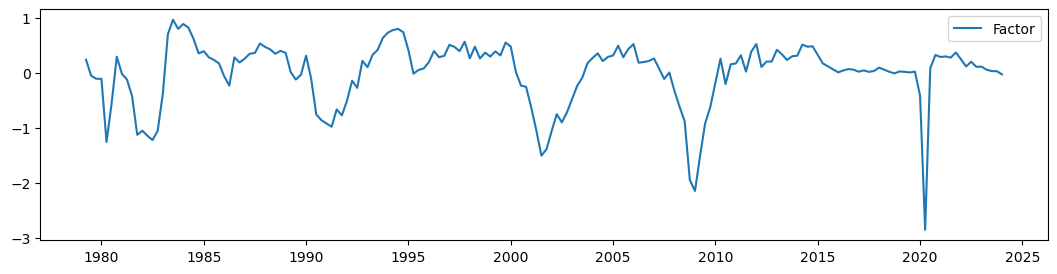

In [85]:
# Отрисовка полученного фактора
fig, ax = plt.subplots(figsize=(13, 3))
dates = endog.index._mpl_repr()
factor_values = res.factors.filtered.iloc[:, 0] * 0.9
ax.plot(dates, factor_values, label='Factor')
ax.legend()
plt.show()

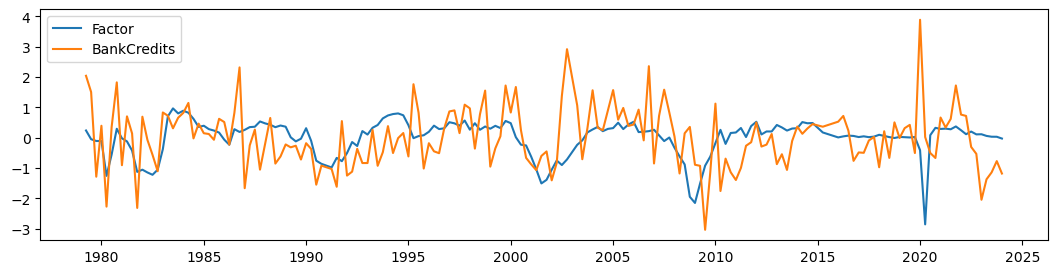

In [86]:
# Отрисовка полученного фактора и истинных значений для сравнения
fig, ax = plt.subplots(figsize=(13,3))
dates = endog.index._mpl_repr()
ax.plot(dates, factor_values, label='Factor')
ax.plot(dates, dta_credits.loc['1979-04-01':, ['STDBankCredits']], label='BankCredits')
ax.legend()
plt.show()

In [87]:
# Котрольный расчёт ошибки MAE
mae = mean_absolute_error(dta_credits.loc['1979-04-01':, 'STDBankCredits'].values, factor_values)
print(f"MAE: {mae}")

MAE: 0.7735823775340865


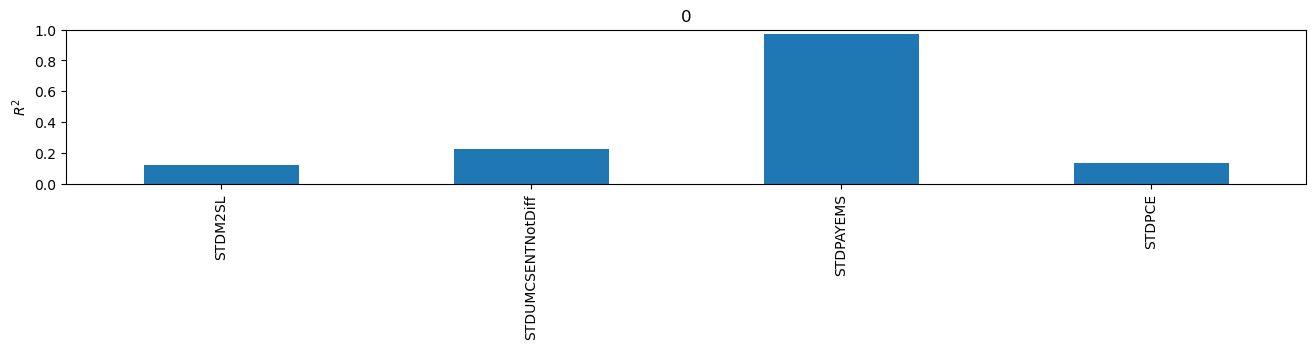

In [88]:
# Просмотр полученных коэффициентов для переменных
res.plot_coefficients_of_determination(figsize=(16,2));

# VAR, предсказывающая спрос на кредиты

In [89]:
columns_to_use = ['STDM2SL', 'STDUMCSENTNotDiff', 'STDPAYEMS', 'STDFEDFUNDS', 'STDUSPHCI', 'STDPCE']
columns_to_use = optimize_var(dta_credits, columns_to_use, 'STDBankCredits')

Progress: 100%|██████████████████████████████████████████████████████████████████████| 84/84 [00:41<00:00,  2.02comb/s]

Лучшая комбинация: ['STDUMCSENTNotDiff', 'STDPAYEMS', 'STDUSPHCI', 'STDPCE', 'STDBankCredits']
Критерий выбора лагов: BIC
Оптимальное количество лагов: 1
Минимальное MAE: 0.7156


## Построение модели с подобранными данными

In [90]:
predictions = []
actuals = []
dates = []
endog = dta_loans.loc['1979-01-01':, ['STDUMCSENTNotDiff', 'STDPAYEMS', 'STDUSPHCI', 'STDPCE', 'STDBankCredits']]
for i in range(40 + 1, len(endog)):
    train_data = endog.iloc[i - 40:i]
    model = VAR(train_data)
    fitted_model = model.fit(1)
    forecast = fitted_model.forecast(train_data.values[-1:], steps=1)
    pred = forecast[0][endog.columns.get_loc('STDBankCredits')]
    predictions.append(pred)
    actuals.append(endog['STDBankCredits'].iloc[i])
    dates.append(endog.index[i])
    results = pd.DataFrame({'date': dates, 'actual': actuals, 'forecast': predictions}).set_index('date')

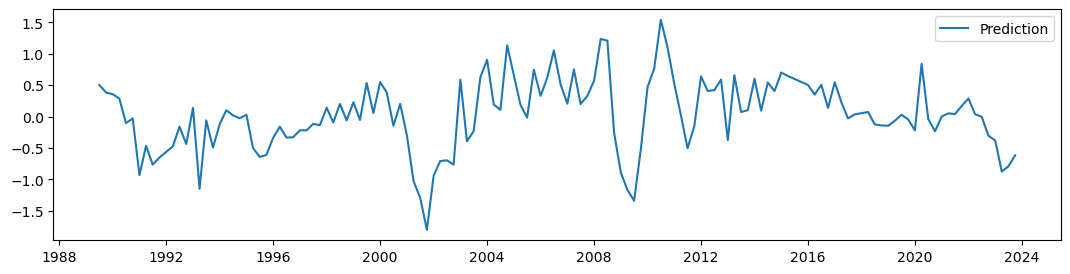

In [91]:
# Отрисовка полученных предиктов
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(results.index, results['forecast'], label='Prediction')
ax.legend()
plt.show()

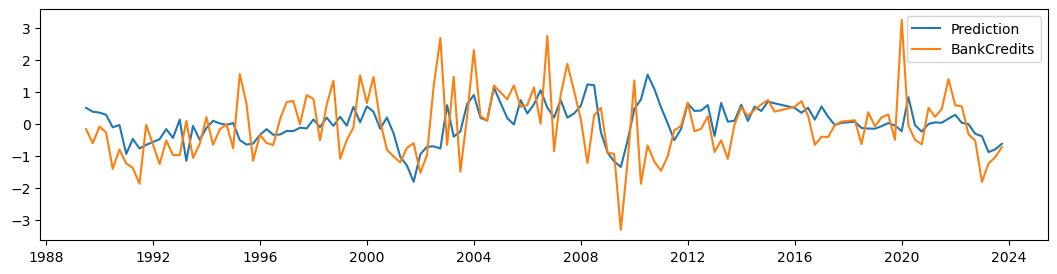

In [92]:
# Отрисовка полученных предиктов и истинных значений для сравнения
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(results.index, results['forecast'], label='Prediction')
ax.plot(results.index, results['actual'], label='BankCredits')
ax.legend()
plt.show()

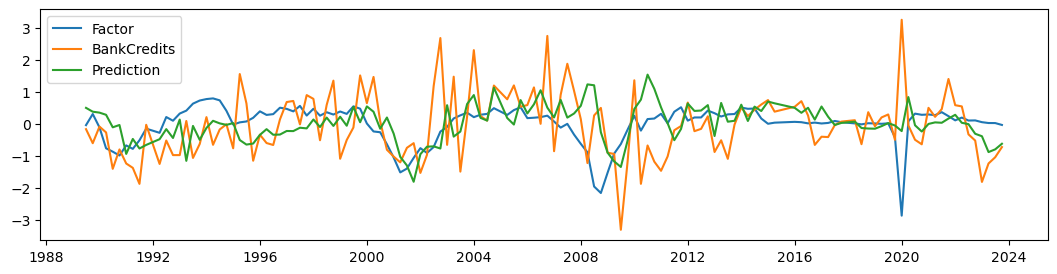

In [93]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(results.index, factor_values[42:], label='Factor')
ax.plot(results.index, results['actual'], label='BankCredits')
ax.plot(results.index, results['forecast'], label='Prediction')
ax.legend()
plt.show()